In [ ]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  CELL 1: Install all dependencies                           ║
# ║  Runtime: ~3-4 minutes on first run                         ║
# ╚══════════════════════════════════════════════════════════════╝
print("📦 Installing dependencies...")
!pip install -q rdkit
!pip install -q xgboost lightgbm
!pip install -q shap
!pip install -q scikit-learn imbalanced-learn
!pip install -q statsmodels
!pip install -q lmfit
!pip install -q openpyxl xlsxwriter
!pip install -q matplotlib seaborn
!pip install -q scipy numpy pandas
print("✅ All dependencies installed.")
print("⚠️  If RDKit import fails below, use Runtime → Restart and run all")

📦 Installing dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 4.1 MB/s eta 0:00:00
✅ All dependencies installed.
⚠️  If RDKit import fails below, use Runtime → Restart and run all


In [ ]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  CELL 2: Imports and configuration                          ║
# ╚══════════════════════════════════════════════════════════════╝
import pandas as pd
import numpy as np
import warnings, io, os, time, zipfile, glob, datetime
warnings.filterwarnings('ignore')

# ── RDKit ──────────────────────────────────────────────────────
from rdkit import Chem, RDLogger
from rdkit.Chem import (
    Descriptors, rdMolDescriptors, AllChem, Draw,
    Crippen, QED
)
from rdkit.Chem.Draw import rdMolDraw2D
RDLogger.DisableLog('rdApp.*')

# ── Machine Learning ────────────────────────────────────────────
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    ExtraTreesClassifier, GradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import (
    StratifiedKFold, cross_validate, cross_val_predict,
    train_test_split
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, precision_score,
    recall_score, matthews_corrcoef, confusion_matrix,
    roc_curve, precision_recall_curve, average_precision_score,
    balanced_accuracy_score, classification_report
)
from sklearn.feature_selection import (
    VarianceThreshold, mutual_info_classif
)
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
import shap

# ── Statistics ──────────────────────────────────────────────────
from scipy import stats, integrate
from scipy.stats import mannwhitneyu, pointbiserialr
from scipy.integrate import solve_ivp
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ── Visualization ───────────────────────────────────────────────
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')

# ── Excel ───────────────────────────────────────────────────────
import openpyxl
from openpyxl import Workbook
from openpyxl.styles import Font, PatternFill, Alignment, Border, Side
from openpyxl.utils import get_column_letter
from openpyxl.formatting.rule import ColorScaleRule

# ── Colab ───────────────────────────────────────────────────────
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    print("ℹ️  Not in Colab – upload steps will use local paths")

np.random.seed(42)
OUTPUT_DIR = '/content/BBB_Results'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("✅ All imports successful")
print(f"📁 Output directory: {OUTPUT_DIR}")

✅ All imports successful
📁 Output directory: /content/BBB_Results


In [ ]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  CELL 3: Descriptor Calculation Functions                    ║
# ║  All 4 descriptor classes per feedback:                      ║
# ║  A) Physicochemical  B) Topological/structural               ║
# ║  C) Electrostatic    D) Binary/categorical flags             ║
# ╚══════════════════════════════════════════════════════════════╝

# ── Helper: BBB Score (Gupta et al. 2019) ──────────────────────
def calc_bbb_score(mol):
    """Composite BBB score (0-6). Score ≥ 4 = BBB+."""
    try:
        mw   = Descriptors.MolWt(mol)
        tpsa = Descriptors.TPSA(mol)
        hbd  = Descriptors.NumHDonors(mol)
        hba  = Descriptors.NumHAcceptors(mol)
        arom = rdMolDescriptors.CalcNumAromaticRings(mol)
        mwhbn = mw / (hbd + hba + 1)
        s = 0
        s += 1.5 if arom == 0 else (1.0 if arom == 1 else (0.5 if arom == 2 else 0))
        s += 1.5 if mwhbn >= 40 else (1.0 if mwhbn >= 20 else 0.5)
        s += 1.0 if tpsa <= 90 else 0
        s += 1.0 if hbd <= 0 else (0.5 if hbd <= 3 else 0)
        s += 1.0 if mw <= 400 else 0
        return round(s, 2)
    except:
        return np.nan

# ── Helper: CNS MPO Score (Wager et al. 2010, Pfizer) ──────────
def calc_cns_mpo(mol):
    """Pfizer CNS MPO score (0-6). Score ≥ 4 = CNS-favourable."""
    try:
        logp = Descriptors.MolLogP(mol)
        tpsa = Descriptors.TPSA(mol)
        hbd  = Descriptors.NumHDonors(mol)
        mw   = Descriptors.MolWt(mol)
        hba  = Descriptors.NumHAcceptors(mol)
        rb   = Descriptors.NumRotatableBonds(mol)
        def clamp(x, lo, hi): return max(lo, min(hi, x))
        s  = clamp(6 - abs(logp - 2.5) / 0.5, 0, 1)
        s += clamp((90 - tpsa) / 10, 0, 1)
        s += 1 if hbd <= 3 else 0
        s += 1 if mw <= 360 else max(0, 1 - (mw - 360) / 40)
        s += 1 if hba <= 8 else 0
        s += 1 if rb <= 8 else 0
        return round(min(s, 6), 3)
    except:
        return np.nan

# ── Helper: Approximate pKa class ──────────────────────────────
def infer_ionization_class(mol):
    """
    Rule-based ionization class at pH 7.4.
    Returns: 'basic', 'acidic', 'zwitterionic', 'neutral'
    This is an approximation; use Epik/MoKa for production.
    """
    try:
        smi = Chem.MolToSmiles(mol)
        has_basic  = any(a.GetAtomicNum() == 7 and
                         a.GetTotalNumHs() > 0 and
                         not a.GetIsAromatic()
                         for a in mol.GetAtoms())
        has_acidic = any(
            '[OH]' in smi or 'C(=O)O' in smi or
            'S(=O)(=O)O' in smi or 'P(=O)(O)O' in smi
            for _ in [1]
        )
        if has_basic and has_acidic: return 'zwitterionic'
        if has_basic:  return 'basic'
        if has_acidic: return 'acidic'
        return 'neutral'
    except:
        return 'unknown'

# ── MAIN DESCRIPTOR FUNCTION ────────────────────────────────────
def get_full_descriptors(smiles):
    """
    Calculate all 4 descriptor classes from SMILES.
    Returns dict or None if SMILES is invalid.

    CLASS A: Physicochemical (size, logP, TPSA, ionization)
    CLASS B: Topological/structural (connectivity, rings, shape)
    CLASS C: Electrostatic (partial charges, polar surface partitions)
    CLASS D: Binary/categorical (functional groups, ionization class flags)
    """
    try:
        if pd.isna(smiles): return None
        mol = Chem.MolFromSmiles(str(smiles).strip())
        if mol is None: return None
    except:
        return None

    d = {}
    try:
        # ── CLASS A: Physicochemical ──────────────────────────────
        d['MW']               = Descriptors.MolWt(mol)
        d['ExactMW']          = Descriptors.ExactMolWt(mol)
        d['HeavyAtomCount']   = mol.GetNumHeavyAtoms()
        d['LogP']             = Descriptors.MolLogP(mol)
        d['TPSA']             = Descriptors.TPSA(mol)
        d['NumHDonors']       = Descriptors.NumHDonors(mol)
        d['NumHAcceptors']    = Descriptors.NumHAcceptors(mol)
        d['NumRotBonds']      = Descriptors.NumRotatableBonds(mol)
        d['MolMR']            = Descriptors.MolMR(mol)
        d['FractionCSP3']     = Descriptors.FractionCSP3(mol)
        d['QED']              = QED.qed(mol)

        # Derived physicochemical
        d['TPSA_per_MW']      = d['TPSA'] / (d['MW'] + 1e-6)
        d['LogP_TPSA_ratio']  = d['LogP'] / (d['TPSA'] + 1e-6)
        d['MW_per_HeavyAtom'] = d['MW'] / (d['HeavyAtomCount'] + 1e-6)

        # ── CLASS B: Topological / structural ─────────────────────
        d['NumRings']         = rdMolDescriptors.CalcNumRings(mol)
        d['NumAromaticRings'] = rdMolDescriptors.CalcNumAromaticRings(mol)
        d['NumAliphRings']    = rdMolDescriptors.CalcNumAliphaticRings(mol)
        d['NumSatRings']      = rdMolDescriptors.CalcNumSaturatedRings(mol)
        d['NumHeteroatoms']   = rdMolDescriptors.CalcNumHeteroatoms(mol)
        d['NumAmideBonds']    = rdMolDescriptors.CalcNumAmideBonds(mol)
        d['NumSpiroAtoms']    = rdMolDescriptors.CalcNumSpiroAtoms(mol)
        d['NumBridgeheads']   = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
        d['NumStereoCenters'] = rdMolDescriptors.CalcNumAtomStereoCenters(mol)
        d['NHOHCount']        = Descriptors.NHOHCount(mol)
        d['NOCount']          = Descriptors.NOCount(mol)

        # Topological indices
        d['BalabanJ']         = Descriptors.BalabanJ(mol)
        d['BertzCT']          = Descriptors.BertzCT(mol)
        d['Chi0']             = Descriptors.Chi0(mol)
        d['Chi1']             = Descriptors.Chi1(mol)
        d['Chi0n']            = Descriptors.Chi0n(mol)
        d['Chi1n']            = Descriptors.Chi1n(mol)
        d['Chi2n']            = Descriptors.Chi2n(mol)
        d['Chi3n']            = Descriptors.Chi3n(mol)
        d['Chi0v']            = Descriptors.Chi0v(mol)
        d['Chi1v']            = Descriptors.Chi1v(mol)
        d['Kappa1']           = Descriptors.Kappa1(mol)
        d['Kappa2']           = Descriptors.Kappa2(mol)
        d['Kappa3']           = Descriptors.Kappa3(mol)

        # ── CLASS C: Electrostatic descriptors ────────────────────
        d['MaxPartialCharge']    = Descriptors.MaxPartialCharge(mol)
        d['MinPartialCharge']    = Descriptors.MinPartialCharge(mol)
        d['MaxAbsPartialCharge'] = Descriptors.MaxAbsPartialCharge(mol)
        d['MinAbsPartialCharge'] = Descriptors.MinAbsPartialCharge(mol)
        d['NumValenceElectrons'] = Descriptors.NumValenceElectrons(mol)
        d['LabuteASA']           = Descriptors.LabuteASA(mol)
        d['PEOE_VSA1']           = Descriptors.PEOE_VSA1(mol)
        d['PEOE_VSA2']           = Descriptors.PEOE_VSA2(mol)
        d['PEOE_VSA3']           = Descriptors.PEOE_VSA3(mol)
        d['SMR_VSA1']            = Descriptors.SMR_VSA1(mol)
        d['SMR_VSA2']            = Descriptors.SMR_VSA2(mol)
        d['SlogP_VSA1']          = Descriptors.SlogP_VSA1(mol)
        d['SlogP_VSA2']          = Descriptors.SlogP_VSA2(mol)

        # ── CLASS D: Binary / categorical flags ───────────────────
        # Lipinski violations
        viol = sum([
            d['MW'] > 500, d['LogP'] > 5,
            d['NumHDonors'] > 5, d['NumHAcceptors'] > 10
        ])
        d['LipinskiViol']     = viol
        d['Lipinski_pass']    = int(viol == 0)  # binary flag

        # Ionization class flags (one-hot)
        ion_class = infer_ionization_class(mol)
        d['Ion_basic']        = int(ion_class == 'basic')
        d['Ion_acidic']       = int(ion_class == 'acidic')
        d['Ion_zwitterionic'] = int(ion_class == 'zwitterionic')
        d['Ion_neutral']      = int(ion_class == 'neutral')

        # Functional group presence flags
        smi = Chem.MolToSmiles(mol)
        d['Has_amide']        = int('C(=O)N' in smi)
        d['Has_amine']        = int(any(a.GetAtomicNum()==7 for a in mol.GetAtoms()))
        d['Has_alcohol']      = int('CO' in smi or 'c[OH]' in smi)
        d['Has_carboxyl']     = int('C(=O)O' in smi)
        d['Has_sulfone']      = int('S(=O)(=O)' in smi)
        d['Has_halogen']      = int(any(a.GetAtomicNum() in [9,17,35,53] for a in mol.GetAtoms()))
        d['Has_aromatic_N']   = int(any(a.GetAtomicNum()==7 and a.GetIsAromatic() for a in mol.GetAtoms()))

        # ── Composite scores ──────────────────────────────────────
        d['BBB_Score']  = calc_bbb_score(mol)
        d['CNS_MPO']    = calc_cns_mpo(mol)

        return d
    except Exception as e:
        return None

# ── Quick sanity check ─────────────────────────────────────────
_test = get_full_descriptors('CN1CCC[C@H]1c2cccnc2')  # nicotine
print(f"✅ Descriptor function working: {len(_test)} descriptors calculated")
print(f"   Descriptor classes: Physicochemical (MW={_test['MW']:.1f}, LogP={_test['LogP']:.2f}, TPSA={_test['TPSA']:.1f})")
print(f"   Topological: Chi1={_test['Chi1']:.2f}, Kappa2={_test['Kappa2']:.2f}, BertzCT={_test['BertzCT']:.1f}")
print(f"   Electrostatic: MaxCharge={_test['MaxPartialCharge']:.3f}, LabuteASA={_test['LabuteASA']:.1f}")
print(f"   Binary flags: Lipinski_pass={_test['Lipinski_pass']}, Ion_basic={_test['Ion_basic']}")
print(f"   Composite: BBB_Score={_test['BBB_Score']}, CNS_MPO={_test['CNS_MPO']}")

✅ Descriptor function working: 66 descriptors calculated
   Descriptor classes: Physicochemical (MW=162.2, LogP=1.85, TPSA=16.1)
   Topological: Chi1=5.88, Kappa2=3.23, BertzCT=245.3
   Electrostatic: MaxCharge=0.036, LabuteASA=73.2
   Binary flags: Lipinski_pass=1, Ion_basic=0
   Composite: BBB_Score=5.5, CNS_MPO=6


In [ ]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  CELL 4: Load & process BBBP training data                  ║
# ╚══════════════════════════════════════════════════════════════╝
print("="*60)
print(" LEVEL 0 → LOAD BENCHMARK BBB TRAINING DATA ")
print("="*60)
print("📥 Downloading BBBP benchmark dataset (DeepChem)...")
url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv"
raw_df = pd.read_csv(url)
print(f"✅ Loaded {len(raw_df)} compounds")
print(f"   BBB+ (penetrant):     {raw_df['p_np'].sum()} ({raw_df['p_np'].mean()*100:.1f}%)")
print(f"   BBB- (non-penetrant): {(raw_df['p_np']==0).sum()} ({(1-raw_df['p_np'].mean())*100:.1f}%)")

print("\n🔬 Calculating descriptors for all training compounds...")
t0 = time.time()
records, labels, smiles_train = [], [], []

for _, row in raw_df.iterrows():
    feat = get_full_descriptors(row['smiles'])
    if feat is not None:
        records.append(feat)
        labels.append(int(row['p_np']))
        smiles_train.append(row['smiles'])

X_all  = pd.DataFrame(records)
y_all  = np.array(labels)
n_invalid = len(raw_df) - len(X_all)

print(f"✅ Descriptors ready: {len(X_all)} compounds × {X_all.shape[1]} descriptors  ({time.time()-t0:.1f}s)")
print(f"   Invalid SMILES removed: {n_invalid}")
print(f"\n📊 Descriptor summary:")
print(X_all[['MW','LogP','TPSA','NumHDonors','NumHAcceptors',
              'BBB_Score','CNS_MPO','FractionCSP3']].describe().round(2).to_string())

 LEVEL 0 → LOAD BENCHMARK BBB TRAINING DATA 
📥 Downloading BBBP benchmark dataset (DeepChem)...
✅ Loaded 2050 compounds
   BBB+ (penetrant):     1567 (76.4%)
   BBB- (non-penetrant): 483 (23.6%)

🔬 Calculating descriptors for all training compounds...
✅ Descriptors ready: 2039 compounds × 66 descriptors  (16.5s)
   Invalid SMILES removed: 11

📊 Descriptor summary:
            MW     LogP     TPSA  NumHDonors  NumHAcceptors  BBB_Score  CNS_MPO  FractionCSP3
count  2039.00  2039.00  2039.00     2039.00        2039.00    2039.00  2039.00       2039.00
mean    344.54     2.32    70.73        1.55           4.44       4.23     5.00          0.46
std     150.65     2.09    58.47        1.84           3.20       1.08     1.42          0.23
min      28.05   -11.74     0.00        0.00           0.00       1.00     0.00          0.00
25%     256.81     1.25    32.78        0.00           2.00       3.50     4.30          0.30
50%     324.41     2.47    55.12        1.00           4.00       4.5

 LEVEL 1 → EDA & DESCRIPTOR CORRELATION 
📊 Running Mann-Whitney U tests (BBB+ vs BBB-)...


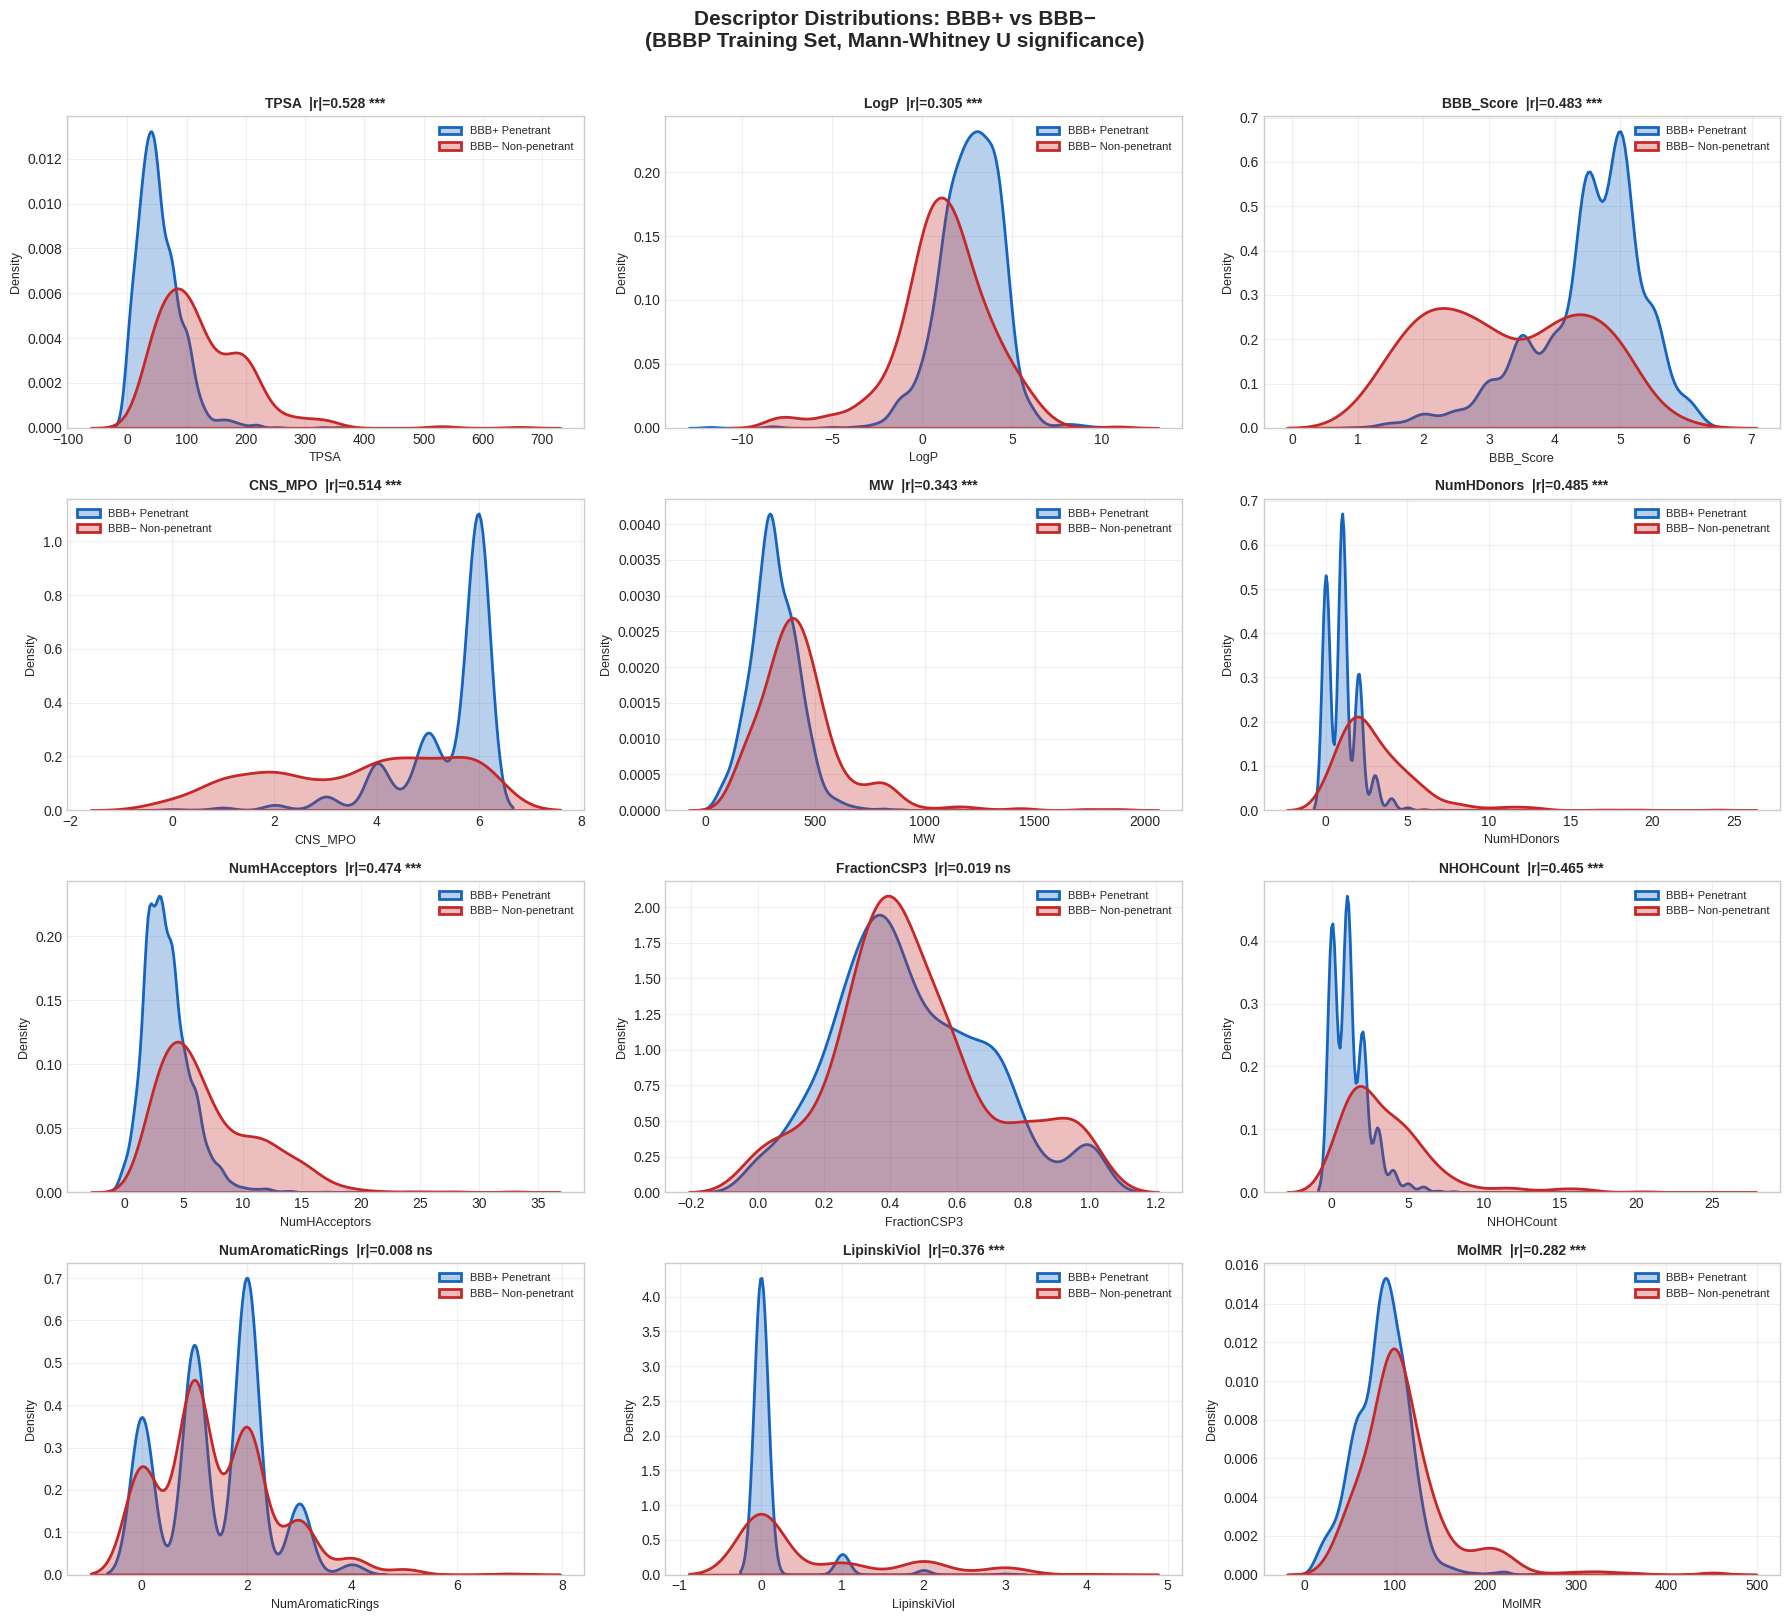

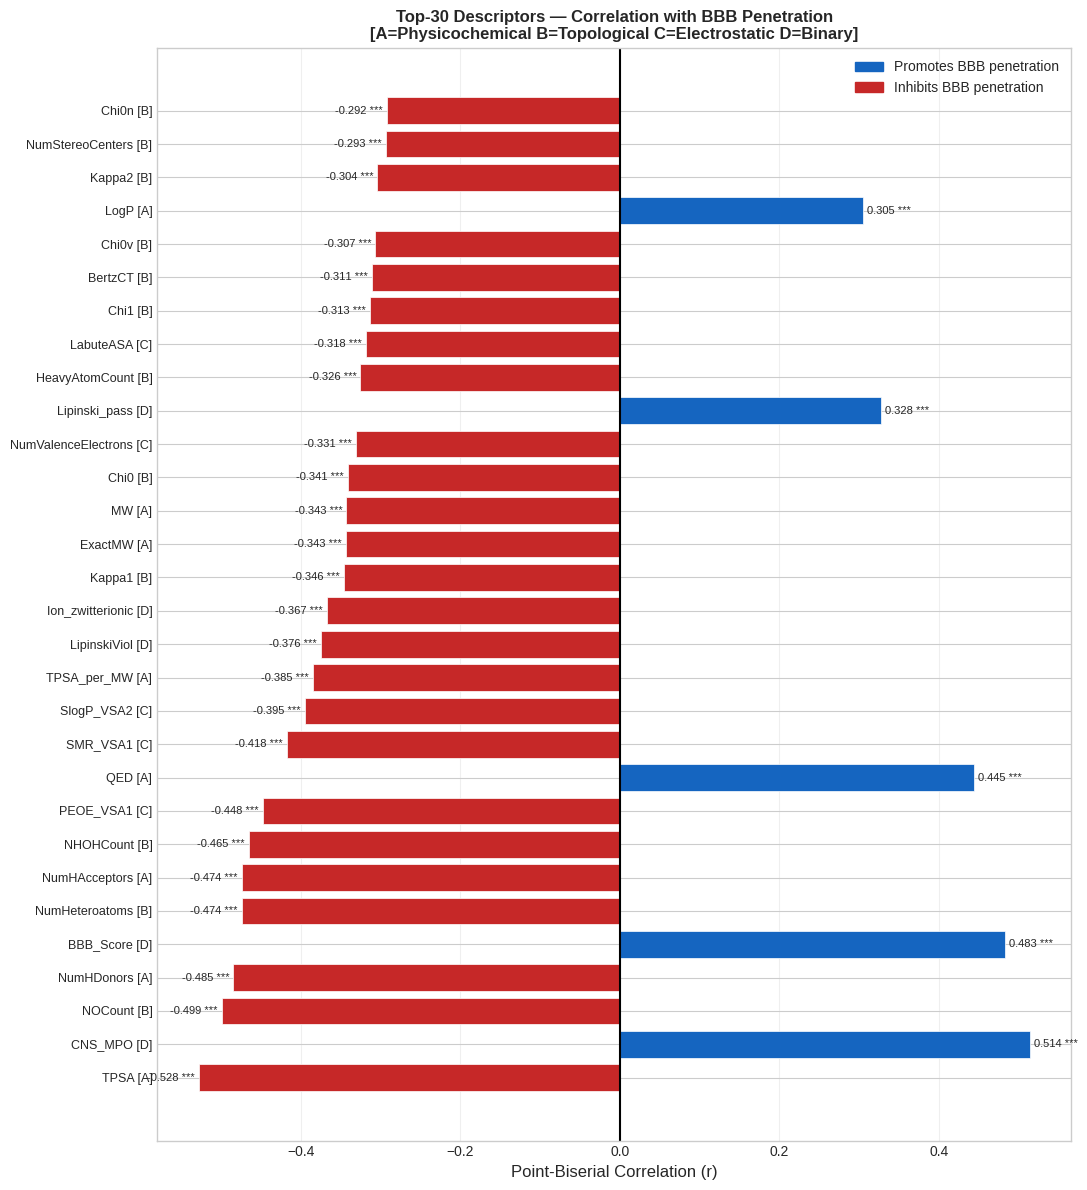


✅ EDA complete. Top 10 BBB-relevant descriptors:
    Descriptor           Class    r_pb       p_value Sig
          TPSA      A-Physchem -0.5283 2.523341e-105 ***
       CNS_MPO        D-Binary  0.5140  3.611052e-90 ***
       NOCount   B-Topological -0.4992  1.339735e-89 ***
    NumHDonors      A-Physchem -0.4849  6.282240e-98 ***
     BBB_Score        D-Binary  0.4835  5.084203e-82 ***
NumHeteroatoms   B-Topological -0.4742  1.047893e-77 ***
 NumHAcceptors      A-Physchem -0.4741  4.739430e-77 ***
     NHOHCount   B-Topological -0.4652  8.045869e-88 ***
     PEOE_VSA1 C-Electrostatic -0.4481  6.852168e-82 ***
           QED      A-Physchem  0.4445  6.807184e-64 ***


In [ ]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  CELL 5: LEVEL 1 – EDA & Descriptor Correlation Analysis    ║
# ╚══════════════════════════════════════════════════════════════╝
print("="*60)
print(" LEVEL 1 → EDA & DESCRIPTOR CORRELATION ")
print("="*60)

# ── Mann-Whitney U test for all descriptors ─────────────────────
print("📊 Running Mann-Whitney U tests (BBB+ vs BBB-)...")
eda_stats = []
for col in X_all.columns:
    pos = X_all.loc[y_all==1, col].dropna()
    neg = X_all.loc[y_all==0, col].dropna()
    if len(pos) > 1 and len(neg) > 1:
        u, p = mannwhitneyu(pos, neg, alternative='two-sided')
        rpb, _ = pointbiserialr(y_all, X_all[col].fillna(X_all[col].median()))
        eda_stats.append({
            'Descriptor': col, 'Class': 'A-Physchem' if col in [
                'MW','ExactMW','LogP','TPSA','NumHDonors','NumHAcceptors',
                'NumRotBonds','MolMR','FractionCSP3','QED',
                'TPSA_per_MW','LogP_TPSA_ratio','MW_per_HeavyAtom'
            ] else ('B-Topological' if col in [
                'NumRings','NumAromaticRings','NumAliphRings','NumSatRings',
                'NumHeteroatoms','NumAmideBonds','NumSpiroAtoms','NumBridgeheads',
                'NumStereoCenters','NHOHCount','NOCount','BalabanJ','BertzCT',
                'Chi0','Chi1','Chi0n','Chi1n','Chi2n','Chi3n','Chi0v','Chi1v',
                'Kappa1','Kappa2','Kappa3','HeavyAtomCount'
            ] else ('C-Electrostatic' if 'Charge' in col or 'VSA' in col or
                    'ASA' in col or 'Valence' in col else 'D-Binary')),
            'BBB+_Mean': round(pos.mean(),3), 'BBB+_Std': round(pos.std(),3),
            'BBB-_Mean': round(neg.mean(),3), 'BBB-_Std': round(neg.std(),3),
            'Delta': round(pos.mean()-neg.mean(),3),
            'r_pb': round(rpb,4), 'p_value': p,
            'Sig': '***' if p<0.001 else ('**' if p<0.01 else ('*' if p<0.05 else 'ns'))
        })

eda_df = pd.DataFrame(eda_stats).sort_values('r_pb', key=abs, ascending=False)

# ── Plot 1: Distribution plots ──────────────────────────────────
KEY_DESC = ['TPSA','LogP','BBB_Score','CNS_MPO','MW','NumHDonors',
            'NumHAcceptors','FractionCSP3','NHOHCount','NumAromaticRings',
            'LipinskiViol','MolMR']

fig, axes = plt.subplots(4, 3, figsize=(18, 16))
fig.suptitle('Descriptor Distributions: BBB+ vs BBB−\n(BBBP Training Set, Mann-Whitney U significance)',
             fontsize=15, fontweight='bold', y=1.01)
for i, col in enumerate(KEY_DESC):
    ax = axes.flatten()[i]
    pos_vals = X_all.loc[y_all==1, col].dropna()
    neg_vals = X_all.loc[y_all==0, col].dropna()
    sns.kdeplot(pos_vals, ax=ax, label='BBB+ Penetrant', color='#1565C0', fill=True, alpha=0.3, linewidth=2)
    sns.kdeplot(neg_vals, ax=ax, label='BBB− Non-penetrant', color='#C62828', fill=True, alpha=0.3, linewidth=2)
    row_stat = eda_df[eda_df['Descriptor']==col]
    sig = row_stat['Sig'].values[0] if len(row_stat) > 0 else ''
    rpb = row_stat['r_pb'].values[0] if len(row_stat) > 0 else 0
    ax.set_title(f'{col}  |r|={abs(rpb):.3f} {sig}', fontsize=10, fontweight='bold')
    ax.set_xlabel(col, fontsize=9); ax.set_ylabel('Density', fontsize=9)
    ax.legend(fontsize=8); ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plot_01_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

# ── Plot 2: Point-biserial correlation bar chart ────────────────
top30 = eda_df.head(30)
colors = ['#1565C0' if r > 0 else '#C62828' for r in top30['r_pb']]

fig, ax = plt.subplots(figsize=(11, 12))
bars = ax.barh(range(len(top30)), top30['r_pb'].values, color=colors, edgecolor='white', linewidth=0.5)
ax.set_yticks(range(len(top30)))
ax.set_yticklabels([f'{d} [{c[0]}]' for d,c in zip(top30['Descriptor'], top30['Class'])], fontsize=9)
ax.axvline(0, color='black', linewidth=1.5)
for bar, r, sig in zip(bars, top30['r_pb'], top30['Sig']):
    ax.text(r + (0.005 if r>0 else -0.005), bar.get_y()+bar.get_height()/2,
            f'{r:.3f} {sig}', va='center', ha='left' if r>0 else 'right', fontsize=8)
ax.set_xlabel('Point-Biserial Correlation (r)', fontsize=12)
ax.set_title('Top-30 Descriptors — Correlation with BBB Penetration\n[A=Physicochemical B=Topological C=Electrostatic D=Binary]',
             fontsize=12, fontweight='bold')
pos_patch = mpatches.Patch(color='#1565C0', label='Promotes BBB penetration')
neg_patch = mpatches.Patch(color='#C62828', label='Inhibits BBB penetration')
ax.legend(handles=[pos_patch, neg_patch], fontsize=10)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plot_02_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ EDA complete. Top 10 BBB-relevant descriptors:")
print(eda_df[['Descriptor','Class','r_pb','p_value','Sig']].head(10).to_string(index=False))

🔎 Running 4-step feature selection pipeline...

📋 Feature selection summary:
   Original descriptors:     66
   After variance filter:    66
   After correlation filter: 44
   After MI filter:          36  (final set)

🔑 Selected features:
    1. TPSA                           MI=0.2158
    2. MinPartialCharge               MI=0.1952
    3. SMR_VSA1                       MI=0.1921
    4. PEOE_VSA1                      MI=0.1739
    5. MaxPartialCharge               MI=0.1631
    6. SlogP_VSA2                     MI=0.1446
    7. BBB_Score                      MI=0.1322
    8. NumHDonors                     MI=0.1312
    9. CNS_MPO                        MI=0.1286
   10. LogP_TPSA_ratio                MI=0.1063
   11. QED                            MI=0.0957
   12. TPSA_per_MW                    MI=0.0928
   13. MW                             MI=0.0803
   14. LogP                           MI=0.0791
   15. NumStereoCenters               MI=0.0762
   16. SlogP_VSA1                     MI

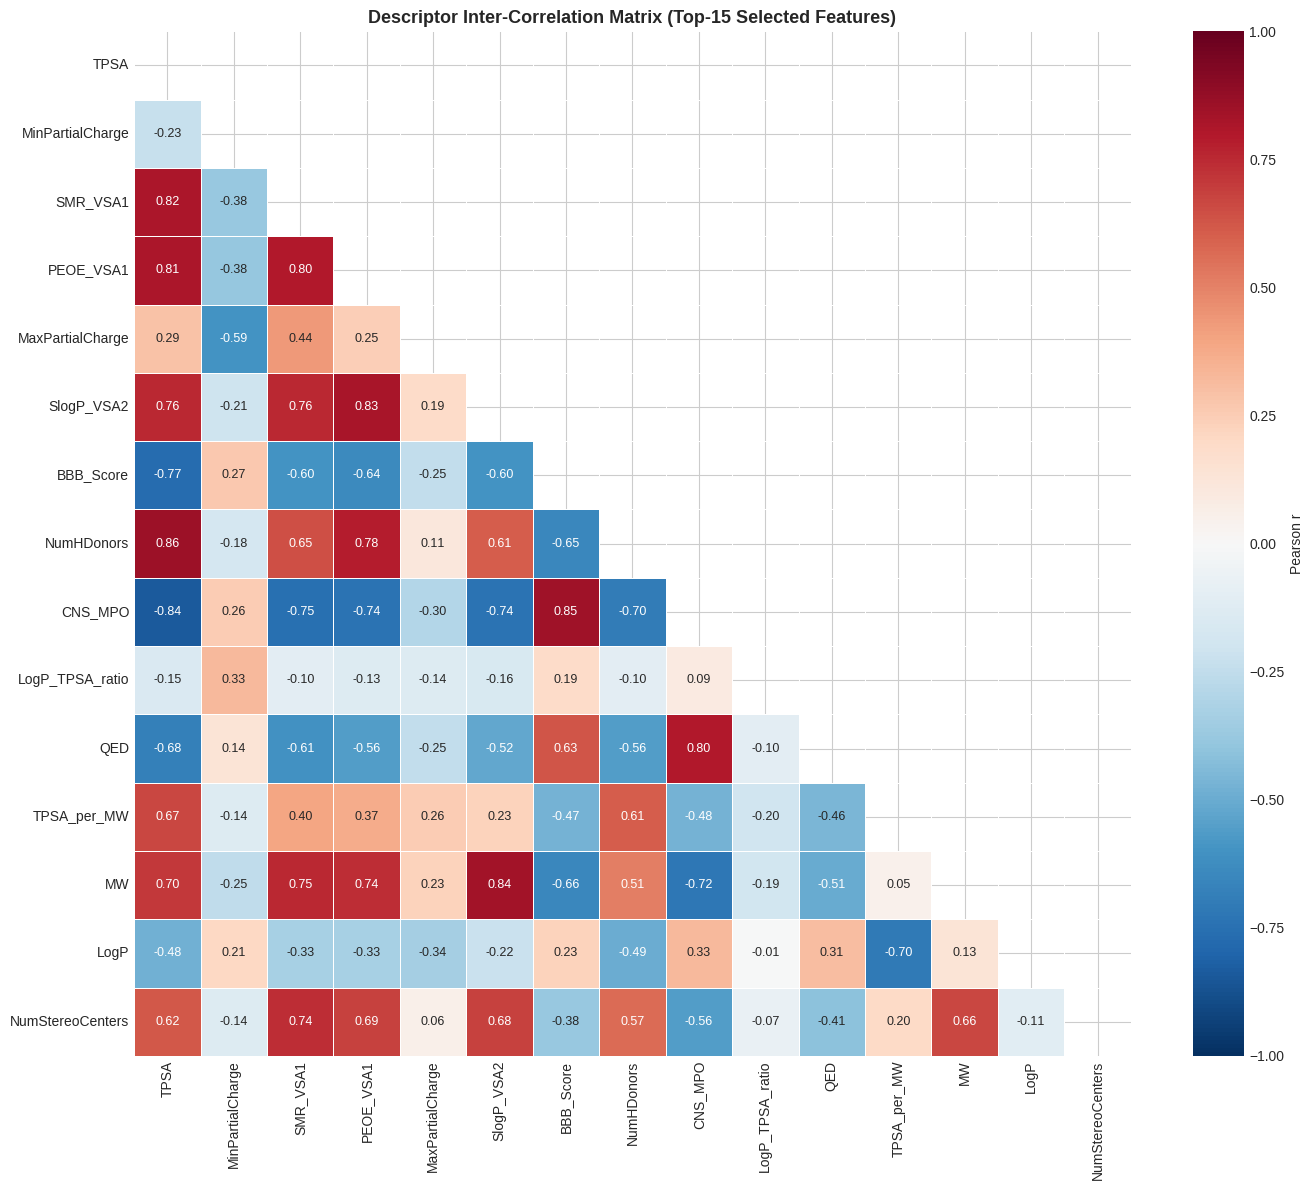

In [ ]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  CELL 6: Feature Selection Pipeline                         ║
# ║  Step 1: Variance filter  Step 2: Correlation filter        ║
# ║  Step 3: Mutual information  Step 4: VIF check              ║
# ╚══════════════════════════════════════════════════════════════╝
print("🔎 Running 4-step feature selection pipeline...")

# ── Pre-processing ──────────────────────────────────────────────
IMPUTER = SimpleImputer(strategy='median')
X_imp   = pd.DataFrame(IMPUTER.fit_transform(X_all), columns=X_all.columns)
SCALER  = StandardScaler()
X_scaled = pd.DataFrame(SCALER.fit_transform(X_imp), columns=X_imp.columns)

# ── Step 1: Variance threshold ──────────────────────────────────
vt = VarianceThreshold(threshold=0.01)
vt.fit(X_imp)
kept_var = X_imp.columns[vt.get_support()].tolist()

# ── Step 2: Remove highly correlated (|r| > 0.90) ───────────────
corr_abs = X_imp[kept_var].corr().abs()
upper    = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))
to_drop  = [c for c in upper.columns if any(upper[c] > 0.90)]
kept_corr = [f for f in kept_var if f not in to_drop]

# ── Step 3: Mutual information filter ───────────────────────────
mi_scores = mutual_info_classif(X_imp[kept_corr], y_all, random_state=42)
mi_df = pd.DataFrame({'feature': kept_corr, 'MI': mi_scores}).sort_values('MI', ascending=False)
SELECTED_FEATURES = mi_df[mi_df['MI'] > 0.005]['feature'].tolist()[:40]

# ── Step 4: VIF check ───────────────────────────────────────────
X_for_vif = X_imp[SELECTED_FEATURES].values
vif_rows = []
for j, f in enumerate(SELECTED_FEATURES):
    try:
        v = variance_inflation_factor(X_for_vif, j)
        vif_rows.append({'Feature': f, 'VIF': round(v, 2)})
    except:
        vif_rows.append({'Feature': f, 'VIF': np.nan})
vif_df = pd.DataFrame(vif_rows).sort_values('VIF', ascending=False)

X_SEL     = X_imp[SELECTED_FEATURES]
X_SEL_SC  = X_scaled[SELECTED_FEATURES]

print(f"\n📋 Feature selection summary:")
print(f"   Original descriptors:     {X_all.shape[1]}")
print(f"   After variance filter:    {len(kept_var)}")
print(f"   After correlation filter: {len(kept_corr)}")
print(f"   After MI filter:          {len(SELECTED_FEATURES)}  (final set)")
print(f"\n🔑 Selected features:")
for i, f in enumerate(SELECTED_FEATURES):
    mi_val = mi_df.loc[mi_df['feature']==f,'MI'].values[0]
    print(f"   {i+1:2d}. {f:<30} MI={mi_val:.4f}")

# ── Correlation heatmap ─────────────────────────────────────────
top15 = SELECTED_FEATURES[:15]
fig, ax = plt.subplots(figsize=(14, 12))
cm = X_imp[top15].corr()
mask = np.triu(np.ones_like(cm, dtype=bool))
sns.heatmap(cm, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, ax=ax, annot_kws={'size': 9},
            linewidths=0.5, cbar_kws={'label': 'Pearson r'})
ax.set_title('Descriptor Inter-Correlation Matrix (Top-15 Selected Features)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plot_03_corr_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  CELL 7: LEVEL 1 – Train ML Models (10-Fold Stratified CV)  ║
# ║  Models: RF, XGBoost, LightGBM, ExtraTrees, GBM, LR        ║
# ╚══════════════════════════════════════════════════════════════╝
print("="*60)
print(" LEVEL 1 → ML MODEL TRAINING (10-FOLD CV) ")
print("="*60)

CV  = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
X_IN = X_SEL.values

pos_weight = (y_all==0).sum() / (y_all==1).sum()  # for class imbalance

MODELS = {
    'Random Forest': RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_split=4,
        min_samples_leaf=2, max_features='sqrt',
        class_weight='balanced', random_state=42, n_jobs=-1),

    'XGBoost': xgb.XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.08,
        subsample=0.8, colsample_bytree=0.8,
        scale_pos_weight=pos_weight,
        eval_metric='logloss', random_state=42,
        verbosity=0, use_label_encoder=False),

    'LightGBM': lgb.LGBMClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.08,
        num_leaves=63, subsample=0.8, min_child_samples=10,
        class_weight='balanced', random_state=42, verbose=-1),

    'Extra Trees': ExtraTreesClassifier(
        n_estimators=300, min_samples_split=4, min_samples_leaf=2,
        class_weight='balanced', random_state=42, n_jobs=-1),

    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.1,
        subsample=0.8, random_state=42),

    'Logistic Regression': Pipeline([
        ('sc', StandardScaler()),
        ('lr', LogisticRegression(
            C=1.0, max_iter=2000, solver='lbfgs',
            class_weight='balanced', random_state=42))
    ])
}

SCORING = ['accuracy','balanced_accuracy','f1','precision',
           'recall','roc_auc','average_precision']

results_rows = []
cv_store     = {}   # per-model: cv_res, oof_proba, oof_pred
trained_models = {}

for name, model in MODELS.items():
    print(f"  ⏳  {name:<25}", end=" ", flush=True)
    t0 = time.time()

    cv_res   = cross_validate(model, X_IN, y_all, cv=CV,
                               scoring=SCORING, n_jobs=-1)
    oof_prob = cross_val_predict(model, X_IN, y_all, cv=CV,
                                  method='predict_proba', n_jobs=-1)[:,1]
    oof_pred = (oof_prob >= 0.5).astype(int)

    model.fit(X_IN, y_all)
    trained_models[name] = model
    cv_store[name] = {'cv_res': cv_res, 'oof_prob': oof_prob, 'oof_pred': oof_pred}

    row = {
        'Model':        name,
        'AUC_ROC':      round(np.mean(cv_res['test_roc_auc']),4),
        'AUC_ROC_std':  round(np.std(cv_res['test_roc_auc']),4),
        'AUC_PR':       round(np.mean(cv_res['test_average_precision']),4),
        'AUC_PR_std':   round(np.std(cv_res['test_average_precision']),4),
        'Accuracy':     round(np.mean(cv_res['test_accuracy']),4),
        'Accuracy_std': round(np.std(cv_res['test_accuracy']),4),
        'Balanced_Acc': round(np.mean(cv_res['test_balanced_accuracy']),4),
        'F1':           round(np.mean(cv_res['test_f1']),4),
        'F1_std':       round(np.std(cv_res['test_f1']),4),
        'Precision':    round(np.mean(cv_res['test_precision']),4),
        'Recall':       round(np.mean(cv_res['test_recall']),4),
        'MCC':          round(matthews_corrcoef(y_all, oof_pred),4),
        'OOF_AUC':      round(roc_auc_score(y_all, oof_prob),4),
        'Time_s':       round(time.time()-t0,1)
    }
    results_rows.append(row)
    print(f"AUC={row['AUC_ROC']:.4f} F1={row['F1']:.4f} MCC={row['MCC']:.4f}  ({row['Time_s']}s)")

results_df = pd.DataFrame(results_rows).sort_values('AUC_ROC', ascending=False).reset_index(drop=True)
BEST_NAME  = results_df.iloc[0]['Model']
BEST_MODEL = trained_models[BEST_NAME]

print(f"\n{'='*60}")
print(f" 🏆 BEST MODEL: {BEST_NAME}  (AUC={results_df.iloc[0]['AUC_ROC']:.4f} ± {results_df.iloc[0]['AUC_ROC_std']:.4f})")
print('='*60)
print(results_df[['Model','AUC_ROC','AUC_PR','F1','MCC','Balanced_Acc']].to_string(index=False))

 LEVEL 1 → ML MODEL TRAINING (10-FOLD CV) 
  ⏳  Random Forest             AUC=0.9225 F1=0.9261 MCC=0.6642  (55.6s)
  ⏳  XGBoost                   AUC=0.9229 F1=0.9269 MCC=0.6847  (11.1s)
  ⏳  LightGBM                  AUC=0.9133 F1=0.9266 MCC=0.6794  (11.3s)
  ⏳  Extra Trees               AUC=0.9268 F1=0.9287 MCC=0.6894  (17.8s)
  ⏳  Gradient Boosting         AUC=0.9168 F1=0.9266 MCC=0.6674  (57.5s)
  ⏳  Logistic Regression       AUC=0.8711 F1=0.8854 MCC=0.5596  (0.8s)

 🏆 BEST MODEL: Extra Trees  (AUC=0.9268 ± 0.0260)
              Model  AUC_ROC  AUC_PR     F1    MCC  Balanced_Acc
        Extra Trees   0.9268  0.9709 0.9287 0.6894        0.8386
            XGBoost   0.9229  0.9689 0.9269 0.6847        0.8391
      Random Forest   0.9225  0.9690 0.9261 0.6642        0.8137
  Gradient Boosting   0.9168  0.9663 0.9266 0.6674        0.8158
           LightGBM   0.9133  0.9649 0.9266 0.6794        0.8335
Logistic Regression   0.8711  0.9476 0.8854 0.5596        0.7962


📈 Generating model evaluation plots...


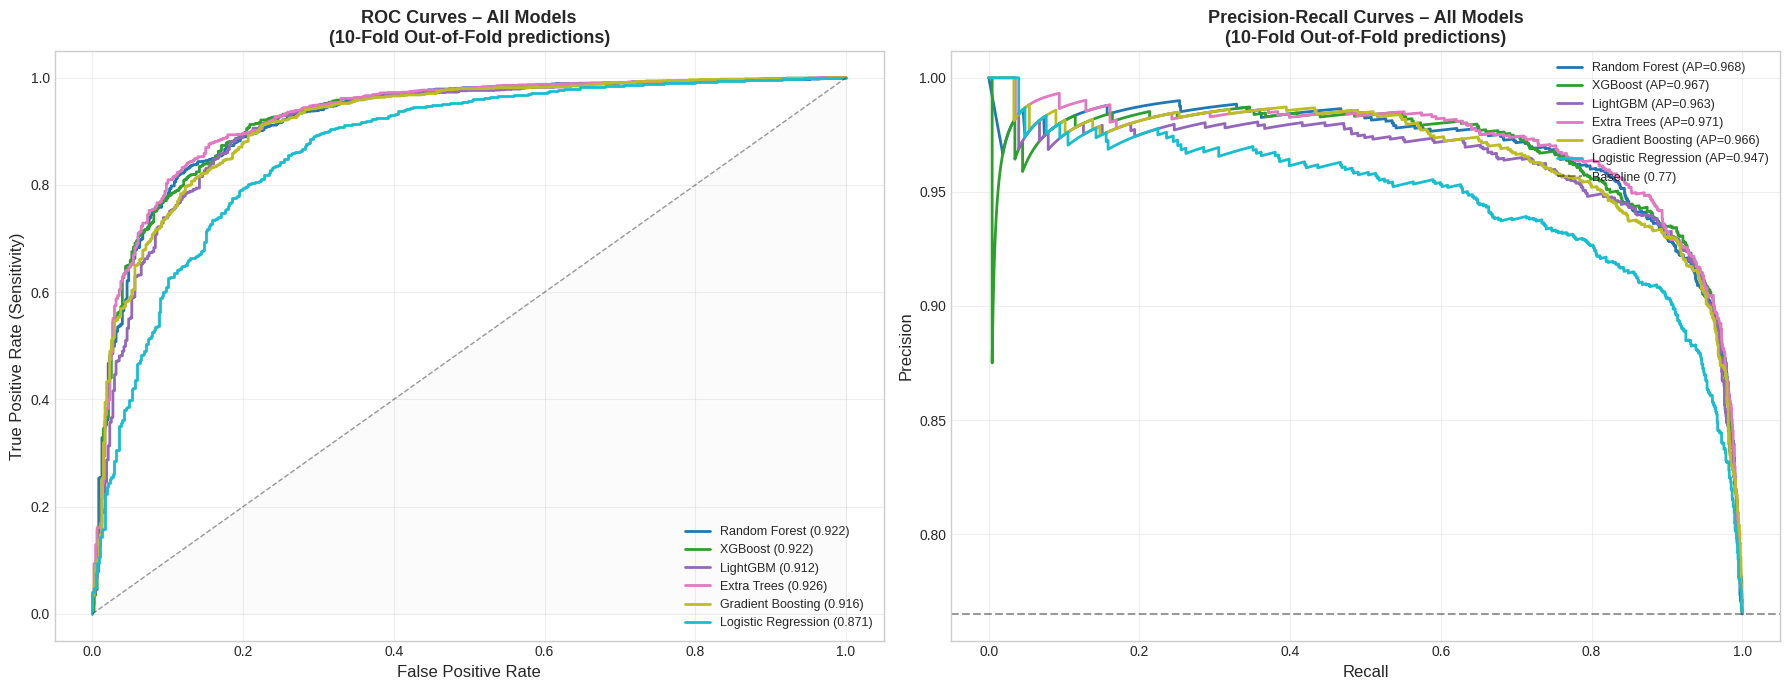

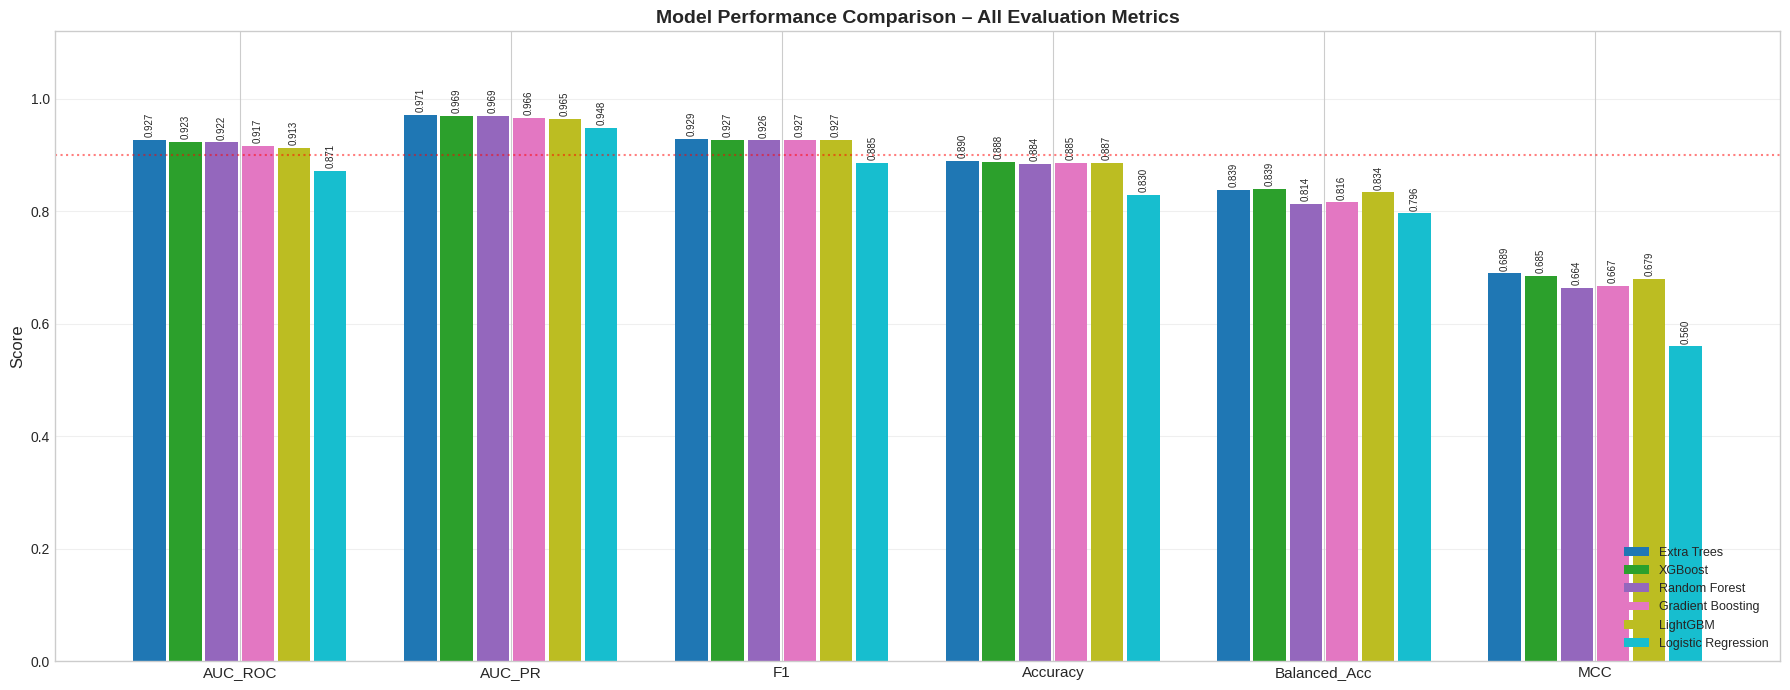

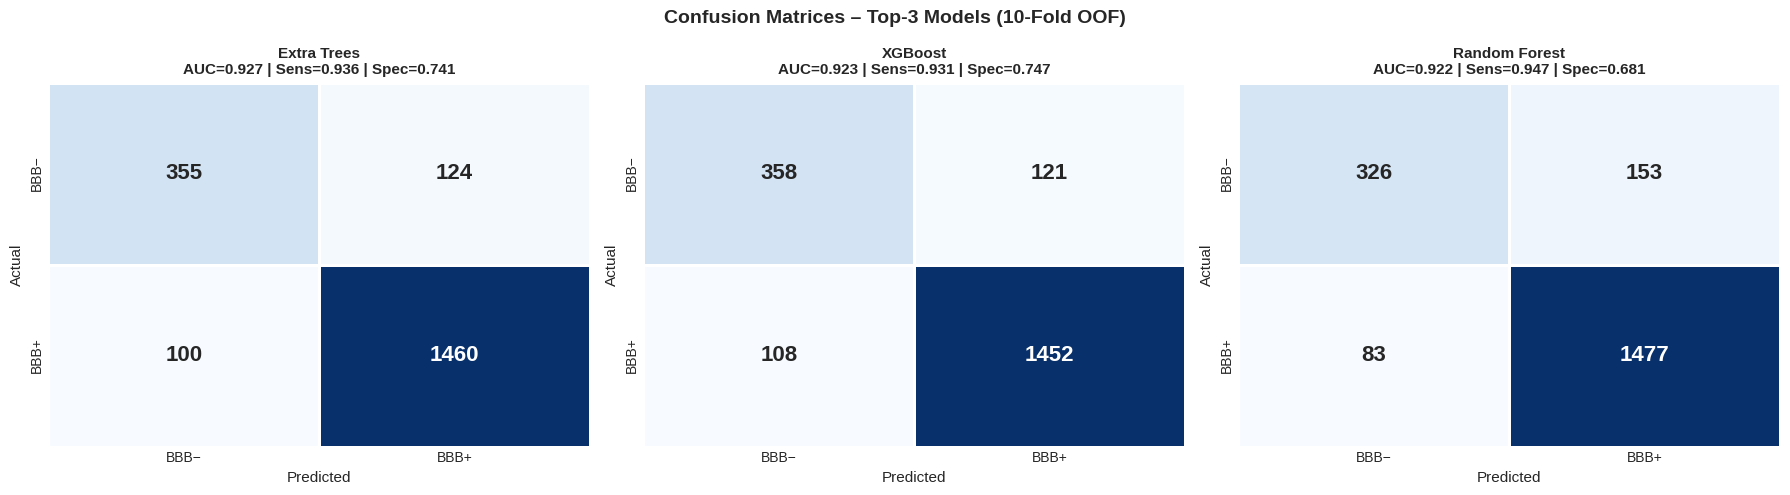

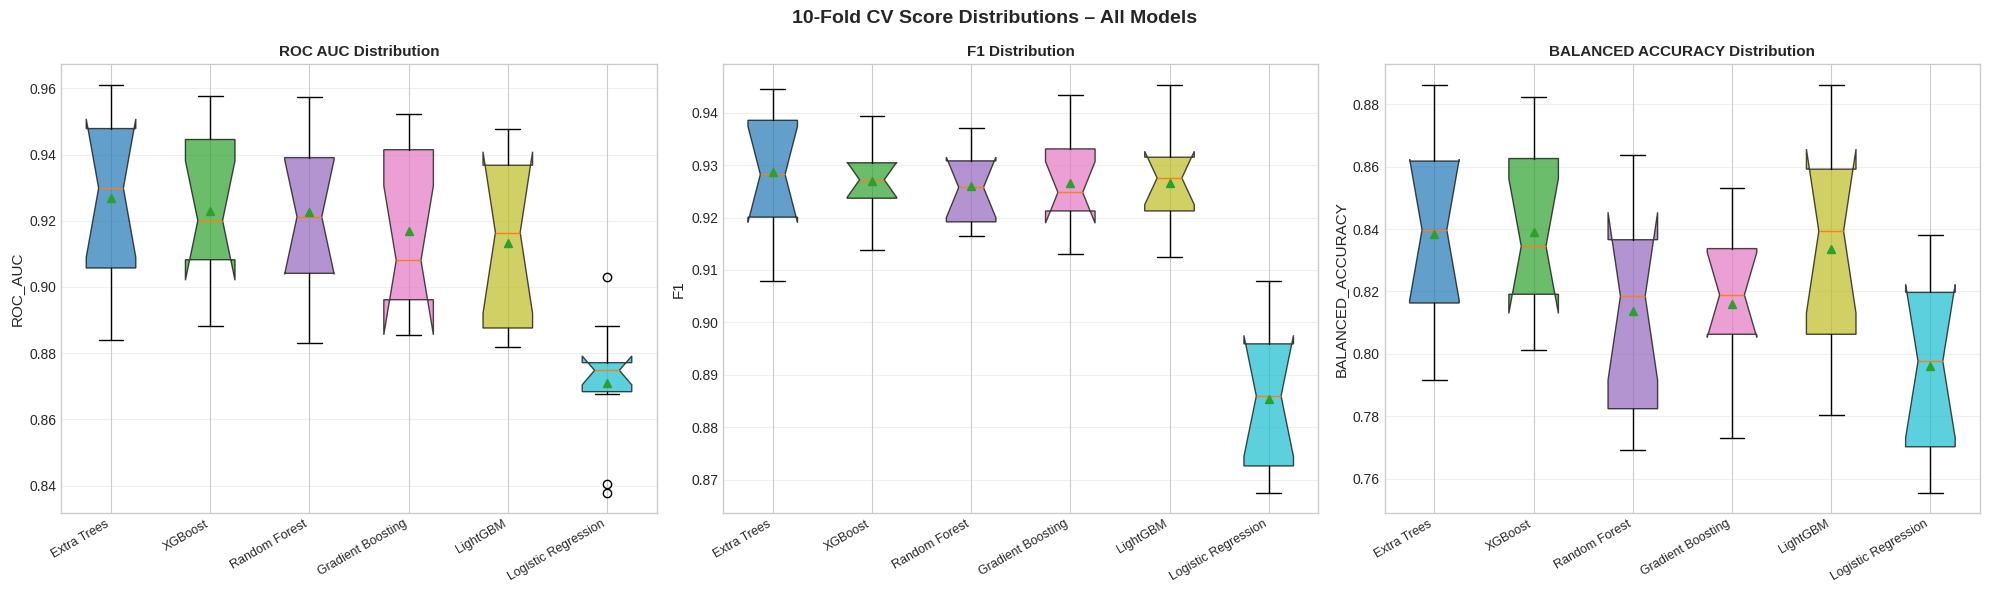

✅ All evaluation plots saved


In [ ]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  CELL 8: Model Evaluation Plots                             ║
# ║  ROC, PR, confusion matrix, CV boxplots                     ║
# ╚══════════════════════════════════════════════════════════════╝
print("📈 Generating model evaluation plots...")
CMAP = plt.cm.tab10(np.linspace(0, 1, len(MODELS)))

# ── ROC + PR curves ─────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for (name, data), col in zip(cv_store.items(), CMAP):
    fpr, tpr, _ = roc_curve(y_all, data['oof_prob'])
    auc = roc_auc_score(y_all, data['oof_prob'])
    axes[0].plot(fpr, tpr, label=f"{name} ({auc:.3f})", color=col, linewidth=2)

axes[0].plot([0,1],[0,1],'k--',alpha=0.4,linewidth=1)
axes[0].fill_between([0,1],[0,1],alpha=0.03,color='gray')
axes[0].set_xlabel('False Positive Rate',fontsize=12)
axes[0].set_ylabel('True Positive Rate (Sensitivity)',fontsize=12)
axes[0].set_title('ROC Curves – All Models\n(10-Fold Out-of-Fold predictions)',fontsize=13,fontweight='bold')
axes[0].legend(loc='lower right',fontsize=9)
axes[0].grid(alpha=0.3)

for (name, data), col in zip(cv_store.items(), CMAP):
    prec, rec, _ = precision_recall_curve(y_all, data['oof_prob'])
    ap = average_precision_score(y_all, data['oof_prob'])
    axes[1].plot(rec, prec, label=f"{name} (AP={ap:.3f})", color=col, linewidth=2)

axes[1].axhline(y_all.mean(), color='k', linestyle='--', alpha=0.4,
                 label=f'Baseline ({y_all.mean():.2f})')
axes[1].set_xlabel('Recall',fontsize=12)
axes[1].set_ylabel('Precision',fontsize=12)
axes[1].set_title('Precision-Recall Curves – All Models\n(10-Fold Out-of-Fold predictions)',fontsize=13,fontweight='bold')
axes[1].legend(loc='upper right',fontsize=9)
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plot_04_roc_pr.png',dpi=150,bbox_inches='tight')
plt.show()

# ── Model comparison bar chart ───────────────────────────────────
metrics = ['AUC_ROC','AUC_PR','F1','Accuracy','Balanced_Acc','MCC']
x = np.arange(len(metrics))
w = 0.8/len(MODELS)
fig, ax = plt.subplots(figsize=(18,7))
for i,(_, row) in enumerate(results_df.iterrows()):
    vals = [row[m] for m in metrics]
    offset = i*w - (len(MODELS)-1)*w/2
    bars = ax.bar(x+offset, vals, w*0.9, label=row['Model'], color=CMAP[i])
    for bar,v in zip(bars,vals):
        ax.text(bar.get_x()+bar.get_width()/2, v+0.005, f'{v:.3f}',
                ha='center',va='bottom',fontsize=7,rotation=90)

ax.set_xticks(x); ax.set_xticklabels(metrics,fontsize=11)
ax.set_ylabel('Score',fontsize=12)
ax.set_title('Model Performance Comparison – All Evaluation Metrics',fontsize=14,fontweight='bold')
ax.legend(loc='lower right',fontsize=9)
ax.set_ylim(0,1.12); ax.axhline(0.9,color='red',linestyle=':',alpha=0.5)
ax.grid(axis='y',alpha=0.3)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plot_05_model_comparison.png',dpi=150,bbox_inches='tight')
plt.show()

# ── Confusion matrices (top 3) ───────────────────────────────────
top3 = results_df.head(3)['Model'].tolist()
fig, axes = plt.subplots(1,3,figsize=(18,5))
for ax_cm, mname in zip(axes, top3):
    cm = confusion_matrix(y_all, cv_store[mname]['oof_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm,
                xticklabels=['BBB−','BBB+'], yticklabels=['BBB−','BBB+'],
                linewidths=1, cbar=False, annot_kws={'size':16,'weight':'bold'})
    tn,fp,fn,tp = cm.ravel()
    sens = tp/(tp+fn); spec = tn/(tn+fp)
    auc_val = results_df.loc[results_df['Model']==mname,'AUC_ROC'].values[0]
    ax_cm.set_title(f'{mname}\nAUC={auc_val:.3f} | Sens={sens:.3f} | Spec={spec:.3f}',
                    fontsize=11,fontweight='bold')
    ax_cm.set_xlabel('Predicted',fontsize=11); ax_cm.set_ylabel('Actual',fontsize=11)

plt.suptitle('Confusion Matrices – Top-3 Models (10-Fold OOF)',fontsize=14,fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plot_06_confusion.png',dpi=150,bbox_inches='tight')
plt.show()

# ── CV boxplots ──────────────────────────────────────────────────
fig, axes = plt.subplots(1,3,figsize=(20,6))
for ax_bx, metric_key in zip(axes, ['test_roc_auc','test_f1','test_balanced_accuracy']):
    plot_data = [cv_store[m]['cv_res'][metric_key] for m in results_df['Model']]
    bp = ax_bx.boxplot(plot_data, labels=results_df['Model'].tolist(),
                        patch_artist=True, notch=True, showmeans=True)
    for patch, col in zip(bp['boxes'], CMAP):
        patch.set_facecolor(col); patch.set_alpha(0.7)
    ax_bx.set_xticklabels(results_df['Model'].tolist(), rotation=30, ha='right', fontsize=9)
    ax_bx.set_ylabel(metric_key.replace('test_','').upper(), fontsize=11)
    ax_bx.set_title(metric_key.replace('test_','').replace('_',' ').upper()+' Distribution',
                    fontsize=11,fontweight='bold')
    ax_bx.grid(axis='y',alpha=0.3)

plt.suptitle('10-Fold CV Score Distributions – All Models',fontsize=14,fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plot_07_cv_boxplots.png',dpi=150,bbox_inches='tight')
plt.show()
print("✅ All evaluation plots saved")

🔍 Running SHAP analysis...
  ⚠️  SHAP failed for Extra Trees: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 500 and the array at index 1 has size 2
  ⚠️  SHAP failed for Random Forest: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 500 and the array at index 1 has size 2


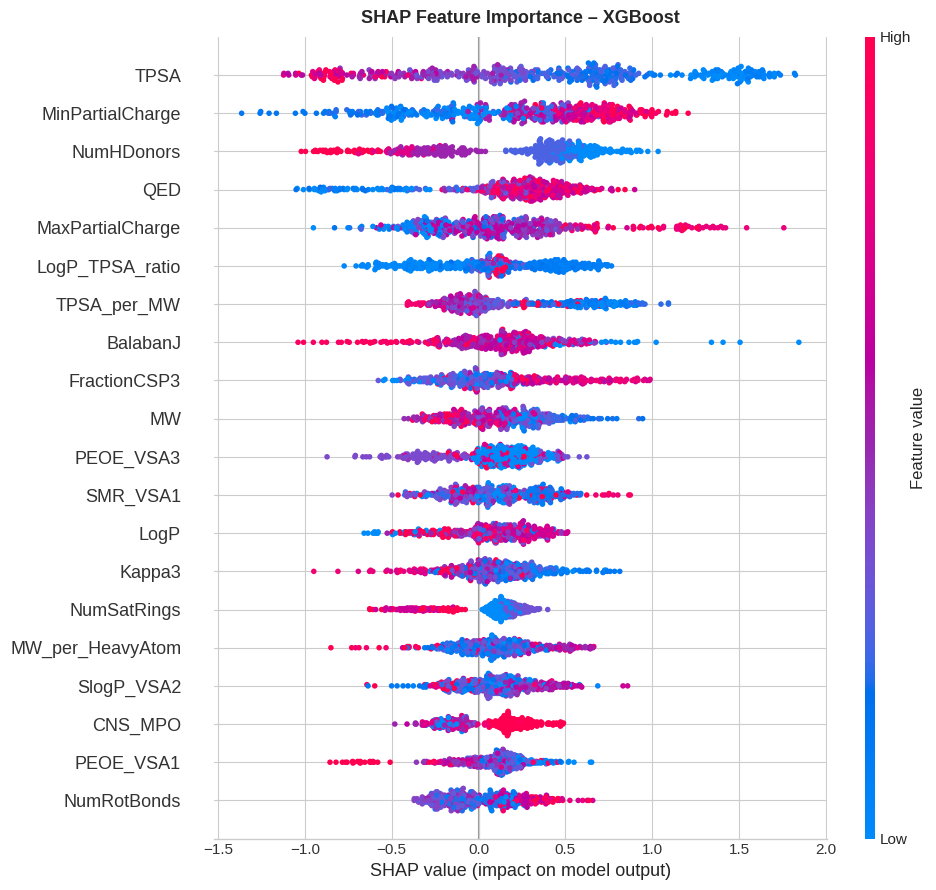

  ✅ SHAP done: XGBoost


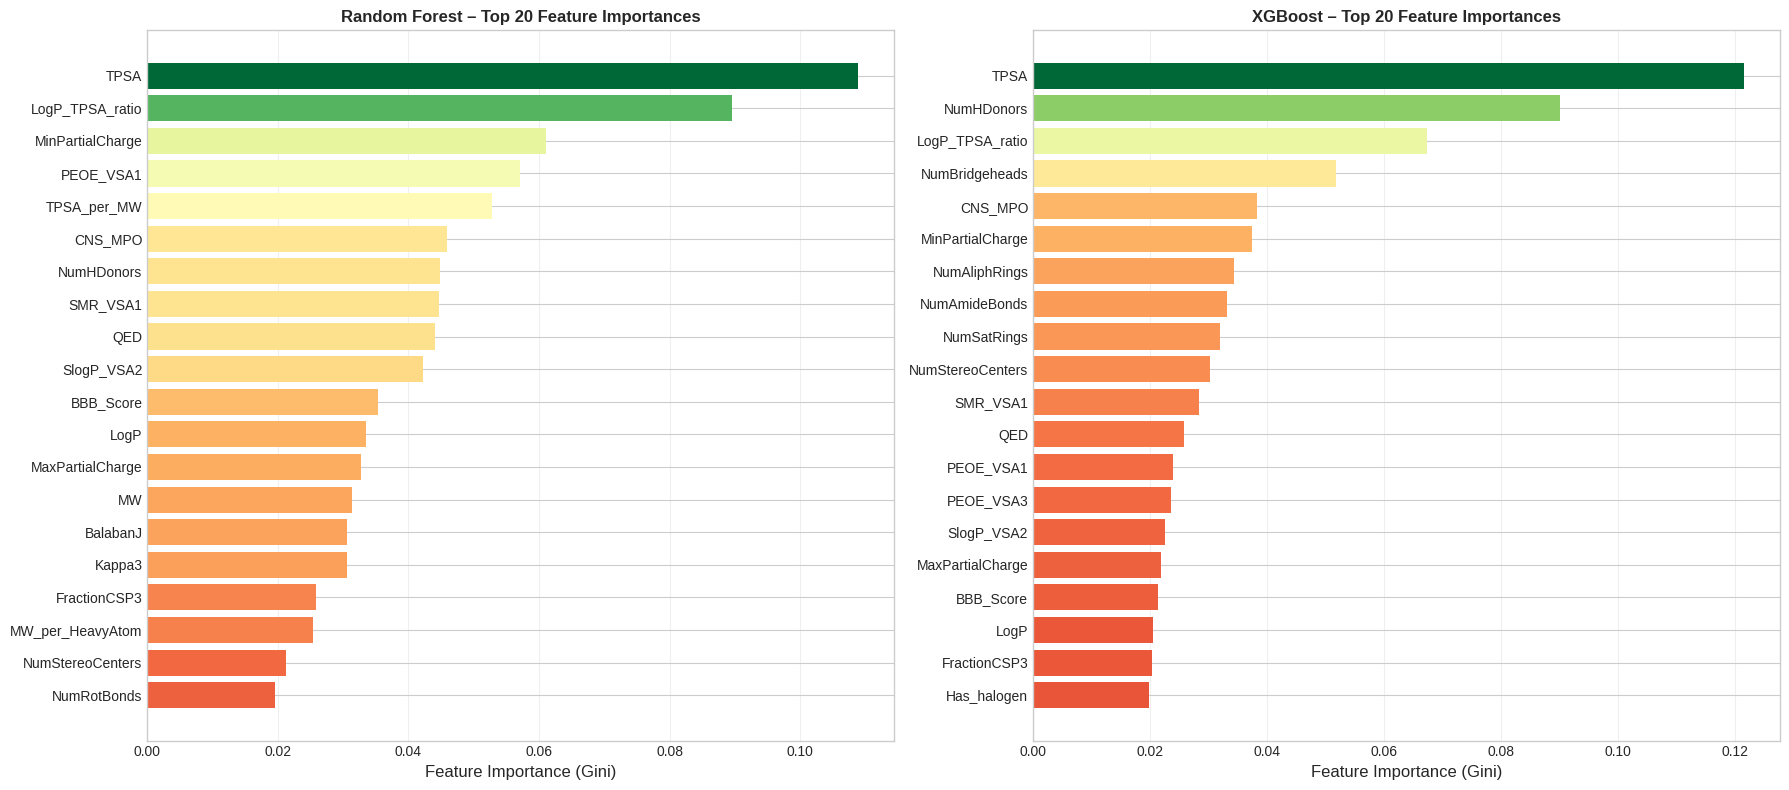

✅ SHAP analysis complete


In [ ]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  CELL 9: SHAP Explainability Analysis                       ║
# ╚══════════════════════════════════════════════════════════════╝
print("🔍 Running SHAP analysis...")

shap_summary_rows = []
N_SHAP = min(500, len(X_IN))
idx_shap = np.random.choice(len(X_IN), N_SHAP, replace=False)
X_shap_sample = X_IN[idx_shap]
y_shap_sample = y_all[idx_shap]

for shap_name in [BEST_NAME, 'Random Forest', 'XGBoost']:
    if shap_name not in trained_models: continue
    m = trained_models[shap_name]
    estimator = m.named_steps[list(m.named_steps.keys())[-1]] if hasattr(m,'named_steps') else m
    try:
        explainer = shap.TreeExplainer(estimator)
        sv = explainer.shap_values(X_shap_sample)
        if isinstance(sv, list): sv = sv[1]

        # Store mean |SHAP| per feature
        mean_shap = np.abs(sv).mean(axis=0)
        for feat, ms in zip(SELECTED_FEATURES, mean_shap):
            # Determine direction: correlation of SHAP values with feature values
            feat_idx = SELECTED_FEATURES.index(feat)
            direction_corr = np.corrcoef(X_shap_sample[:,feat_idx], sv[:,feat_idx])[0,1]
            shap_summary_rows.append({
                'Model': shap_name, 'Feature': feat,
                'Mean_SHAP': round(ms,5),
                'Direction': '↑BBB+' if direction_corr > 0 else '↓BBB+'
            })

        # SHAP summary plot
        fig, ax = plt.subplots(figsize=(10,9))
        shap.summary_plot(sv, X_shap_sample, feature_names=SELECTED_FEATURES,
                          max_display=20, show=False, plot_size=None)
        plt.title(f'SHAP Feature Importance – {shap_name}',fontsize=13,fontweight='bold',pad=10)
        plt.tight_layout()
        safe = shap_name.replace(' ','_').replace('(','').replace(')','').replace('/','_')
        plt.savefig(f'{OUTPUT_DIR}/plot_08_shap_{safe}.png',dpi=150,bbox_inches='tight')
        plt.show()
        print(f"  ✅ SHAP done: {shap_name}")
    except Exception as e:
        print(f"  ⚠️  SHAP failed for {shap_name}: {e}")

shap_df = pd.DataFrame(shap_summary_rows)

# ── Feature importance comparison (RF vs XGBoost) ───────────────
fig, axes = plt.subplots(1,2,figsize=(18,8))
for ax_fi, mname in zip(axes, ['Random Forest','XGBoost']):
    if mname not in trained_models: continue
    m = trained_models[mname]
    est = m.named_steps[list(m.named_steps.keys())[-1]] if hasattr(m,'named_steps') else m
    imp = pd.Series(est.feature_importances_, index=SELECTED_FEATURES).sort_values(ascending=True).tail(20)
    cols_fi = plt.cm.RdYlGn(imp.values/imp.values.max())
    ax_fi.barh(range(len(imp)), imp.values, color=cols_fi)
    ax_fi.set_yticks(range(len(imp))); ax_fi.set_yticklabels(imp.index, fontsize=10)
    ax_fi.set_xlabel('Feature Importance (Gini)',fontsize=12)
    ax_fi.set_title(f'{mname} – Top 20 Feature Importances',fontsize=12,fontweight='bold')
    ax_fi.grid(axis='x',alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plot_09_feature_importance.png',dpi=150,bbox_inches='tight')
plt.show()
print("✅ SHAP analysis complete")

In [ ]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  CELL 10: UPLOAD YOUR QUERY COMPOUNDS                       ║
# ║  Required: CSV with a column named 'SMILES' or 'smiles'     ║
# ║  Optional extra columns (Name, ID, etc.) are preserved      ║
# ╚══════════════════════════════════════════════════════════════╝
print("="*60)
print(" UPLOAD YOUR QUERY COMPOUNDS ")
print("="*60)
print()
print("📋 INSTRUCTIONS:")
print("   • Upload a CSV file with at least one column named 'SMILES' or 'smiles'")
print("   • You may include any other columns (Name, ID, CAS, etc.) — they will be kept")
print("   • One compound per row")
print("   • SMILES should be valid RDKit-parseable strings")
print()
print("📎 Example CSV format:")
print("   SMILES,Name")
print("   CN1CCC[C@H]1c2cccnc2,Nicotine")
print("   CC(=O)Oc1ccccc1C(=O)O,Aspirin")
print()

USER_DF = None

if IN_COLAB:
    print("👆 Click the 'Choose Files' button below to upload your CSV:")
    uploaded = files.upload()

    if uploaded:
        fname = list(uploaded.keys())[0]
        USER_DF = pd.read_csv(io.BytesIO(uploaded[fname]))
        print(f"\n✅ Uploaded: {fname}")
    else:
        print("\n⚠️  No file uploaded. Using built-in demo compounds instead.")
else:
    # ── Local mode: set path here ──────────────────────────────
    LOCAL_PATH = None  # e.g. '/path/to/your/compounds.csv'
    if LOCAL_PATH and os.path.exists(LOCAL_PATH):
        USER_DF = pd.read_csv(LOCAL_PATH)
    else:
        print("ℹ️  Local mode: using demo compounds. Set LOCAL_PATH above for your own file.")

# ── Fallback: demo compounds ─────────────────────────────────────
DEMO_SMILES = [
    # Known BBB+
    ('CN1CCC[C@H]1c2cccnc2',           'Nicotine',         'Known BBB+'),
    ('c1ccc2[nH]ccc2c1',                'Indole',            'Known BBB+'),
    ('CCc1ccc(N(C)C)cc1',               'DMAE-analog',       'Known BBB+'),
    ('c1ccc(-c2ccncc2)cc1',             '4-Phenylpyridine',  'Known BBB+'),
    ('C1CCNCC1',                        'Piperidine',        'Known BBB+'),
    ('Cc1ccc(C(C)(C)C)cc1',             'tButyltoluene',     'Known BBB+'),
    ('CCN(CC)CCOC(=O)c1ccc(N)cc1',      'Procaine',          'Moderate BBB'),
    # Known BBB-
    ('CC(=O)Oc1ccccc1C(=O)O',           'Aspirin',           'Known BBB-'),
    ('O=C(O)c1ccc(N)cc1',               '4-Aminobenzoic acid','Known BBB-'),
    ('OC(=O)CCCCC(=O)O',                'Adipic acid',       'Known BBB-'),
    ('O=C(O)c1ccccc1O',                 'Salicylic acid',    'Known BBB-'),
    ('NC(=O)c1cccnc1',                  'Nicotinamide',      'Moderate BBB'),
    # Your test cases
    ('COc1ccc2[nH]cc(CC(N)C(=O)O)c2c1','5-Methoxytryptophan','Test'),
    ('O=C(NCCc1ccc(O)cc1)CCc1ccc(O)cc1','Bis-tyrosine amide','Test'),
]
demo_df = pd.DataFrame(DEMO_SMILES, columns=['SMILES','Name','Reference'])

if USER_DF is None:
    USER_DF = demo_df
    print("✅ Using demo compounds (14 compounds)")

# ── Identify SMILES column ───────────────────────────────────────
SMILES_COL = next((c for c in USER_DF.columns if c.lower() == 'smiles'), None)
if SMILES_COL is None:
    raise ValueError("❌ No 'SMILES' column found! Please rename your SMILES column to 'SMILES'.")

print(f"\n📊 Dataset overview:")
print(f"   Total rows:    {len(USER_DF)}")
print(f"   SMILES column: '{SMILES_COL}'")
print(f"   Other columns: {[c for c in USER_DF.columns if c != SMILES_COL]}")
USER_DF.head()

 UPLOAD YOUR QUERY COMPOUNDS 

📋 INSTRUCTIONS:
   • Upload a CSV file with at least one column named 'SMILES' or 'smiles'
   • You may include any other columns (Name, ID, CAS, etc.) — they will be kept
   • One compound per row
   • SMILES should be valid RDKit-parseable strings

📎 Example CSV format:
   SMILES,Name
   CN1CCC[C@H]1c2cccnc2,Nicotine
   CC(=O)Oc1ccccc1C(=O)O,Aspirin

👆 Click the 'Choose Files' button below to upload your CSV:


Saving test_data.csv to test_data (1).csv

✅ Uploaded: test_data (1).csv

📊 Dataset overview:
   Total rows:    60
   SMILES column: 'smiles'
   Other columns: ['id']


,smiles,id
0,COC(=O)[C@H](Cc1ccc(-n2c(=O)c3cc(N(C)C)ccc3n(C...,AJM300_methyester
1,CN(C)c1ccc2c(c1)c(=O)n(-c1ccc(C[C@H](NC(=O)c3c...,AJM300_acid
2,CCOC(=O)[C@H](Cc1ccc(-n2c(=O)c3ccncc3n(C)c2=O)...,gilead_GS1427_ester
3,Cc1cc(N2CCOC[C@@H]2C(F)(F)F)cc(F)c1C(=O)N[C@@H...,gilead_GS1427_acid
4,CC[C@H](Nc1cc(F)c(C(=O)N[C@@H](Cc2ccc(C3=C(C=C...,16series_1


In [ ]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  CELL 11: LEVEL 1 – Predict BBB for User Compounds          ║
# ╚══════════════════════════════════════════════════════════════╝
print("="*60)
print(" LEVEL 1 → BBB PREDICTION FOR YOUR COMPOUNDS ")
print("="*60)
print(f"🔬 Calculating descriptors for {len(USER_DF)} compounds...")

user_recs, user_valid_idx, user_valid_smiles = [], [], []
invalid_smiles = []

for idx, row in USER_DF.iterrows():
    smi = str(row[SMILES_COL]).strip()
    feat = get_full_descriptors(smi)
    if feat is not None:
        user_recs.append(feat)
        user_valid_idx.append(idx)
        user_valid_smiles.append(smi)
    else:
        invalid_smiles.append(smi)

print(f"   Valid: {len(user_recs)} | Invalid/skipped: {len(invalid_smiles)}")
if invalid_smiles:
    print(f"   Invalid SMILES: {invalid_smiles[:5]}{'...' if len(invalid_smiles)>5 else ''}")

X_user_raw = pd.DataFrame(user_recs)

# Align columns to training set
for col in X_all.columns:
    if col not in X_user_raw.columns:
        X_user_raw[col] = np.nan
X_user_raw = X_user_raw[X_all.columns]

# Impute & select
X_user_imp = pd.DataFrame(IMPUTER.transform(X_user_raw), columns=X_all.columns)
X_user_sel = X_user_imp[SELECTED_FEATURES]

# ── Predict with all models ──────────────────────────────────────
PRED_OUT = USER_DF.iloc[user_valid_idx].copy().reset_index(drop=True)
PRED_OUT[SMILES_COL] = user_valid_smiles

prob_cols_all = []
for mname, model in trained_models.items():
    proba = model.predict_proba(X_user_sel.values)[:,1]
    pred  = (proba >= 0.5).astype(int)
    safe  = mname.replace(' ','_').replace('(','').replace(')','').replace('/','_')
    PRED_OUT[f'{safe}_Prob']  = np.round(proba, 4)
    PRED_OUT[f'{safe}_Class'] = ['BBB+' if p==1 else 'BBB-' for p in pred]
    prob_cols_all.append(f'{safe}_Prob')

# Ensemble (majority vote)
class_cols = [c for c in PRED_OUT.columns if c.endswith('_Class')]
prob_cols   = [c for c in PRED_OUT.columns if c.endswith('_Prob')]
PRED_OUT['Ensemble_Prob']  = PRED_OUT[prob_cols].mean(axis=1).round(4)
PRED_OUT['Ensemble_Class'] = PRED_OUT[class_cols].apply(
    lambda row: 'BBB+' if (row=='BBB+').sum() > len(class_cols)/2 else 'BBB-', axis=1
)

# Best model primary result
best_safe = BEST_NAME.replace(' ','_').replace('(','').replace(')','').replace('/','_')
PRED_OUT['BEST_BBB_Prob']   = PRED_OUT[f'{best_safe}_Prob']
PRED_OUT['BEST_BBB_Class']  = PRED_OUT[f'{best_safe}_Class']
PRED_OUT['BEST_Model']      = BEST_NAME

# Confidence tier
def confidence_tier(p):
    if p >= 0.75:  return '🟢 High Conf BBB+'
    if p >= 0.50:  return '🔵 Moderate BBB+'
    if p >= 0.25:  return '🟡 Uncertain'
    return '🔴 BBB-'
PRED_OUT['Confidence_Tier'] = PRED_OUT['BEST_BBB_Prob'].apply(confidence_tier)

# Attach key descriptors
for col in ['MW','LogP','TPSA','NumHDonors','NumHAcceptors','NumRotBonds',
            'BBB_Score','CNS_MPO','FractionCSP3','NHOHCount','LipinskiViol','MolMR',
            'Ion_basic','Ion_acidic','Ion_neutral','QED']:
    if col in X_user_imp.columns:
        PRED_OUT[col] = X_user_imp[col].values

print(f"\n✅ Predictions complete for {len(PRED_OUT)} compounds")
print("\n📊 BBB Classification Summary:")
print(PRED_OUT['BEST_BBB_Class'].value_counts().to_string())
print("\n📊 Confidence Tier Distribution:")
print(PRED_OUT['Confidence_Tier'].value_counts().to_string())

display_cols = [SMILES_COL, 'BEST_BBB_Prob', 'BEST_BBB_Class', 'Confidence_Tier',
                'Ensemble_Class', 'BBB_Score', 'CNS_MPO', 'LogP', 'TPSA']
display_cols = [c for c in display_cols if c in PRED_OUT.columns]
PRED_OUT[display_cols].head(10)

 LEVEL 1 → BBB PREDICTION FOR YOUR COMPOUNDS 
🔬 Calculating descriptors for 60 compounds...
   Valid: 60 | Invalid/skipped: 0

✅ Predictions complete for 60 compounds

📊 BBB Classification Summary:
BEST_BBB_Class
BBB-    59
BBB+     1

📊 Confidence Tier Distribution:
Confidence_Tier
🟡 Uncertain        58
🔴 BBB-              1
🔵 Moderate BBB+     1


,smiles,BEST_BBB_Prob,BEST_BBB_Class,Confidence_Tier,Ensemble_Class,BBB_Score,CNS_MPO,LogP,TPSA
0,COC(=O)[C@H](Cc1ccc(-n2c(=O)c3cc(N(C)C)ccc3n(C...,0.4895,BBB-,🟡 Uncertain,BBB-,2.0,4.0,3.57630,102.64
1,CN(C)c1ccc2c(c1)c(=O)n(-c1ccc(C[C@H](NC(=O)c3c...,0.4985,BBB-,🟡 Uncertain,BBB+,2.0,4.0,2.15320,116.47
2,CCOC(=O)[C@H](Cc1ccc(-n2c(=O)c3ccncc3n(C)c2=O)...,0.4827,BBB-,🟡 Uncertain,BBB-,2.0,3.0,3.75182,137.65
3,Cc1cc(N2CCOC[C@@H]2C(F)(F)F)cc(F)c1C(=O)N[C@@H...,0.4247,BBB-,🟡 Uncertain,BBB-,2.0,3.0,1.93862,151.48
4,CC[C@H](Nc1cc(F)c(C(=O)N[C@@H](Cc2ccc(C3=C(C=C...,0.2263,BBB-,🔴 BBB-,BBB-,2.0,2.0,6.38442,113.32
5,Cc1cc(cc(F)c1C(=O)N[C@@H](Cc1ccc(-n2c(=O)n(C)c...,0.2582,BBB-,🟡 Uncertain,BBB-,2.0,4.0,3.27332,148.65
6,Cc1cc(cc(F)c1C(=O)N[C@@H](Cc1ccc(-n2c(=O)n(C)c...,0.2582,BBB-,🟡 Uncertain,BBB-,2.0,4.0,3.27332,148.65
7,Cc1cc(cc(F)c1C(=O)N[C@@H](Cc1ccc(-n2c(=O)n(C)c...,0.2897,BBB-,🟡 Uncertain,BBB-,2.0,3.0,3.89432,137.65
8,CCN(CC)CCOC(=O)[C@H](Cc1ccc(-n2c(=O)n(C)c3cncc...,0.4320,BBB-,🟡 Uncertain,BBB+,2.0,2.0,4.07372,140.89
9,Cc1cc(cc(F)c1C(=O)N[C@@H](Cc1ccc(-n2c(=O)n(C)c...,0.2980,BBB-,🟡 Uncertain,BBB+,2.0,3.0,4.79432,137.65


In [ ]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  CELL 12: LEVEL 2 – Mechanistic PK Decomposition            ║
# ║  Compute: P-gp class, fup, fubrain, Kp,brain, Kp,uu,brain  ║
# ║  Based on: J.Med.Chem. 2021 tiered framework                ║
# ╚══════════════════════════════════════════════════════════════╝
print("="*60)
print(" LEVEL 2 → MECHANISTIC PK DECOMPOSITION ")
print("="*60)
print("Computing: P-gp efflux class, fup, fubrain, Kp,brain, Kp,uu,brain")
print("(Rule-based approximations calibrated to literature ranges)")
print()

def predict_pgp_class(row):
    """
    Rule-based P-gp efflux classification (Low / Medium / High).
    Calibrated to NER values from J.Med.Chem. 2021:
      Low P-gp: NER ~1.0  (essentially no efflux)
      Med P-gp: NER ~2.2  (moderate efflux)
      High P-gp: NER ~26.3 (strong efflux)

    Key P-gp substrate indicators:
    - High MW & HBD (P-gp recognises polar, larger substrates)
    - Basic nitrogen with high LogP (classic P-gp pharmacophore)
    - Multiple H-bond acceptors (amide bonds)
    """
    mw   = row.get('MW', 300)
    logp = row.get('LogP', 2)
    hbd  = row.get('NumHDonors', 1)
    hba  = row.get('NumHAcceptors', 4)
    tpsa = row.get('TPSA', 60)
    ar   = row.get('NumAromaticRings', 1)
    iob  = row.get('Ion_basic', 0)   # basic nitrogen flag
    amide = row.get('NumAmideBonds', 0)

    score = 0
    if mw > 450: score += 2
    elif mw > 350: score += 1

    if hbd >= 3: score += 2
    elif hbd == 2: score += 1

    if hba >= 6: score += 1

    if logp > 3 and iob: score += 1  # basic lipophilic compound

    if tpsa > 120: score += 2        # very polar → likely P-gp substrate
    elif tpsa > 90: score += 1

    if amide >= 2: score += 1        # amide-rich peptide-like → P-gp
    if ar >= 3: score += 1           # high aromatic count

    if score >= 5:   return 'High',   26.3
    elif score >= 2: return 'Medium', 2.2
    else:            return 'Low',    1.0


def predict_fup(row):
    """
    Predict plasma unbound fraction (fup).
    Range: 0.01 – 0.99
    Lower fup = more protein-bound = less free drug.
    Key drivers: logP (albumin binding), acidic compounds (strong albumin binders)
    """
    logp = row.get('LogP', 2)
    mw   = row.get('MW', 300)
    acid = row.get('Ion_acidic', 0)
    basic = row.get('Ion_basic', 0)
    # Empirical approximation (Lobell & Sivarajah, Drug Disc Today 2003)
    fup = np.exp(-0.33 * logp + 0.3 * basic - 0.5 * acid - 0.002 * mw + 0.5)
    return round(np.clip(fup, 0.005, 0.99), 4)


def predict_fubrain(row):
    """
    Predict brain unbound fraction (fubrain).
    Range: 0.001 – 0.99
    Key driver: logP (lipophilic compounds have very high brain binding → low fubrain)
    """
    logp = row.get('LogP', 2)
    hbd  = row.get('NumHDonors', 1)
    # Based on Fridén et al. 2010 (brain binding model)
    fubrain = np.exp(-0.42 * logp + 0.1 * hbd - 0.3)
    return round(np.clip(fubrain, 0.001, 0.99), 4)


def rodgers_kp_brain(row):
    """
    Simplified Rodgers & Rowland Kp,brain estimation.
    Uses: fup, logP, MW as proxies for tissue partitioning.
    Full Rodgers equation requires phospholipid content + ionization data.
    Reference: Rodgers & Rowland, J. Pharm. Sci. 2006
    """
    logp   = row.get('LogP', 2)
    fup    = row.get('fup', 0.1)
    basic  = row.get('Ion_basic', 0)
    neutral= row.get('Ion_neutral', 1)

    # Brain:plasma partition (passive component)
    # logKp,brain ≈ 0.35*logP + 0.3*basic + log(fup correction)
    log_kp = 0.35 * logp + 0.3 * basic - np.log10(fup + 0.01) * 0.2
    kp = 10 ** log_kp
    return round(np.clip(kp, 0.01, 200), 4)


def calc_kp_uu(kp_brain, ner, fup, fubrain):
    """
    Calculate Kp,uu,brain (unbound brain-to-unbound plasma partition).

    Formula: Kp,uu,brain = Kp,brain / NER * (fup / fubrain)

    Kp,uu,brain interpretation:
      > 1.0   : Net accumulation in brain
      0.3-1.0 : Good CNS exposure
      0.1-0.3 : Moderate, efflux-limited
      < 0.1   : Poor CNS exposure (strong efflux or binding)
    """
    try:
        kp_uu = (kp_brain / ner) * (fup / fubrain)
        return round(np.clip(kp_uu, 0.0001, 500), 5)
    except:
        return np.nan


def classify_limitation(row):
    """Root-cause classification from Kp,brain, NER, fup, fubrain."""
    kp_uu  = row['Kp_uu_brain']
    ner    = row['P_gp_NER']
    kpb    = row['Kp_brain']
    fub    = row['fubrain']

    if kp_uu >= 0.3 and kpb >= 0.5:                return '✅ Good CNS exposure'
    if ner >= 10:                                    return '⚠️ Efflux-limited (high P-gp)'
    if fub < 0.05 and kpb >= 0.5:                  return '⚠️ Binding-limited (brain)'
    if kpb < 0.1:                                   return '❌ Permeability-limited'
    if ner >= 2 and kpb < 0.3:                     return '❌ Efflux + permeability'
    return '⚠️ Uncertain – experimental data needed'


# ── Apply to predicted compounds ────────────────────────────────
mech_rows = []
for _, row in PRED_OUT.iterrows():
    pgp_class, ner = predict_pgp_class(row)
    fup     = predict_fup(row)
    fubrain = predict_fubrain(row)
    kp      = rodgers_kp_brain({**row, 'fup': fup})
    kp_uu   = calc_kp_uu(kp, ner, fup, fubrain)
    mech_rows.append({
        'P_gp_Class': pgp_class, 'P_gp_NER': ner,
        'fup': fup, 'fubrain': fubrain,
        'Kp_brain': kp, 'Kp_uu_brain': kp_uu
    })

mech_df = pd.DataFrame(mech_rows)
for col in mech_df.columns:
    PRED_OUT[col] = mech_df[col].values

PRED_OUT['Limitation_Class'] = PRED_OUT.apply(classify_limitation, axis=1)

# ── Decision matrix per feedback ────────────────────────────────
def level1_decision(row):
    tpsa  = row.get('TPSA', 100)
    logp  = row.get('LogP', 2)
    pgp   = row.get('P_gp_Class', 'Medium')
    bbb_p = row.get('BEST_BBB_Prob', 0.5)
    if tpsa > 90 and logp < 1:     return '❌ Deprioritize CNS (high TPSA + low logP)'
    if pgp == 'High':               return '❌ Kill or redesign (strong P-gp efflux)'
    if pgp == 'Medium' and bbb_p >= 0.5: return '✅ Advance (moderate P-gp, good BBB)'
    if bbb_p >= 0.5:               return '✅ Advance'
    return '⚠️ Flag for further investigation'

PRED_OUT['L1_Decision'] = PRED_OUT.apply(level1_decision, axis=1)

print("✅ Mechanistic PK calculations complete")
print("\n📊 P-gp Efflux Class Distribution:")
print(PRED_OUT['P_gp_Class'].value_counts().to_string())
print("\n📊 CNS Limitation Class:")
print(PRED_OUT['Limitation_Class'].value_counts().to_string())
print("\n📊 Level-1 Decision:")
print(PRED_OUT['L1_Decision'].value_counts().to_string())

display_cols2 = ['SMILES' if SMILES_COL=='SMILES' else SMILES_COL,
                  'BEST_BBB_Class','P_gp_Class','fup','fubrain',
                  'Kp_brain','Kp_uu_brain','Limitation_Class','L1_Decision']
PRED_OUT[[c for c in display_cols2 if c in PRED_OUT.columns]].head(10)

 LEVEL 2 → MECHANISTIC PK DECOMPOSITION 
Computing: P-gp efflux class, fup, fubrain, Kp,brain, Kp,uu,brain
(Rule-based approximations calibrated to literature ranges)

✅ Mechanistic PK calculations complete

📊 P-gp Efflux Class Distribution:
P_gp_Class
High      51
Medium     9

📊 CNS Limitation Class:
Limitation_Class
✅ Good CNS exposure              56
⚠️ Efflux-limited (high P-gp)     4

📊 Level-1 Decision:
L1_Decision
❌ Kill or redesign (strong P-gp efflux)      50
⚠️ Flag for further investigation             8
✅ Advance (moderate P-gp, good BBB)           1
❌ Deprioritize CNS (high TPSA + low logP)     1


,smiles,BEST_BBB_Class,P_gp_Class,fup,fubrain,Kp_brain,Kp_uu_brain,Limitation_Class,L1_Decision
0,COC(=O)[C@H](Cc1ccc(-n2c(=O)c3cc(N(C)C)ccc3n(C...,BBB-,High,0.2189,0.1823,47.8383,2.18413,✅ Good CNS exposure,❌ Kill or redesign (strong P-gp efflux)
1,CN(C)c1ccc2c(c1)c(=O)n(-c1ccc(C[C@H](NC(=O)c3c...,BBB-,Medium,0.3608,0.3314,13.7972,6.82782,✅ Good CNS exposure,⚠️ Flag for further investigation
2,CCOC(=O)[C@H](Cc1ccc(-n2c(=O)c3ccncc3n(C)c2=O)...,BBB-,High,0.1564,0.1694,58.7363,2.06193,✅ Good CNS exposure,❌ Kill or redesign (strong P-gp efflux)
3,Cc1cc(N2CCOC[C@@H]2C(F)(F)F)cc(F)c1C(=O)N[C@@H...,BBB-,High,0.3015,0.3627,12.0178,0.37985,✅ Good CNS exposure,❌ Kill or redesign (strong P-gp efflux)
4,CC[C@H](Nc1cc(F)c(C(=O)N[C@@H](Cc2ccc(C3=C(C=C...,BBB-,High,0.0524,0.0685,200.0000,5.81721,✅ Good CNS exposure,❌ Kill or redesign (strong P-gp efflux)
5,Cc1cc(cc(F)c1C(=O)N[C@@H](Cc1ccc(-n2c(=O)n(C)c...,BBB-,High,0.1435,0.2288,20.3442,0.48516,✅ Good CNS exposure,❌ Kill or redesign (strong P-gp efflux)
6,Cc1cc(cc(F)c1C(=O)N[C@@H](Cc1ccc(-n2c(=O)n(C)c...,BBB-,High,0.1435,0.2288,20.3442,0.48516,✅ Good CNS exposure,❌ Kill or redesign (strong P-gp efflux)
7,Cc1cc(cc(F)c1C(=O)N[C@@H](Cc1ccc(-n2c(=O)n(C)c...,BBB-,High,0.1079,0.1595,35.3760,0.90994,✅ Good CNS exposure,❌ Kill or redesign (strong P-gp efflux)
8,CCN(CC)CCOC(=O)[C@H](Cc1ccc(-n2c(=O)n(C)c3cncc...,BBB-,High,0.1220,0.1479,79.7420,2.50105,✅ Good CNS exposure,❌ Kill or redesign (strong P-gp efflux)
9,Cc1cc(cc(F)c1C(=O)N[C@@H](Cc1ccc(-n2c(=O)n(C)c...,BBB-,High,0.0746,0.1093,78.0797,2.02629,✅ Good CNS exposure,❌ Kill or redesign (strong P-gp efflux)


 LEVEL 3/4 → PBPK BRAIN EXPOSURE SIMULATION 
Two-compartment model: Plasma ↔ Brain
Scenarios: Normal conditions vs P-gp inhibited (DDI)



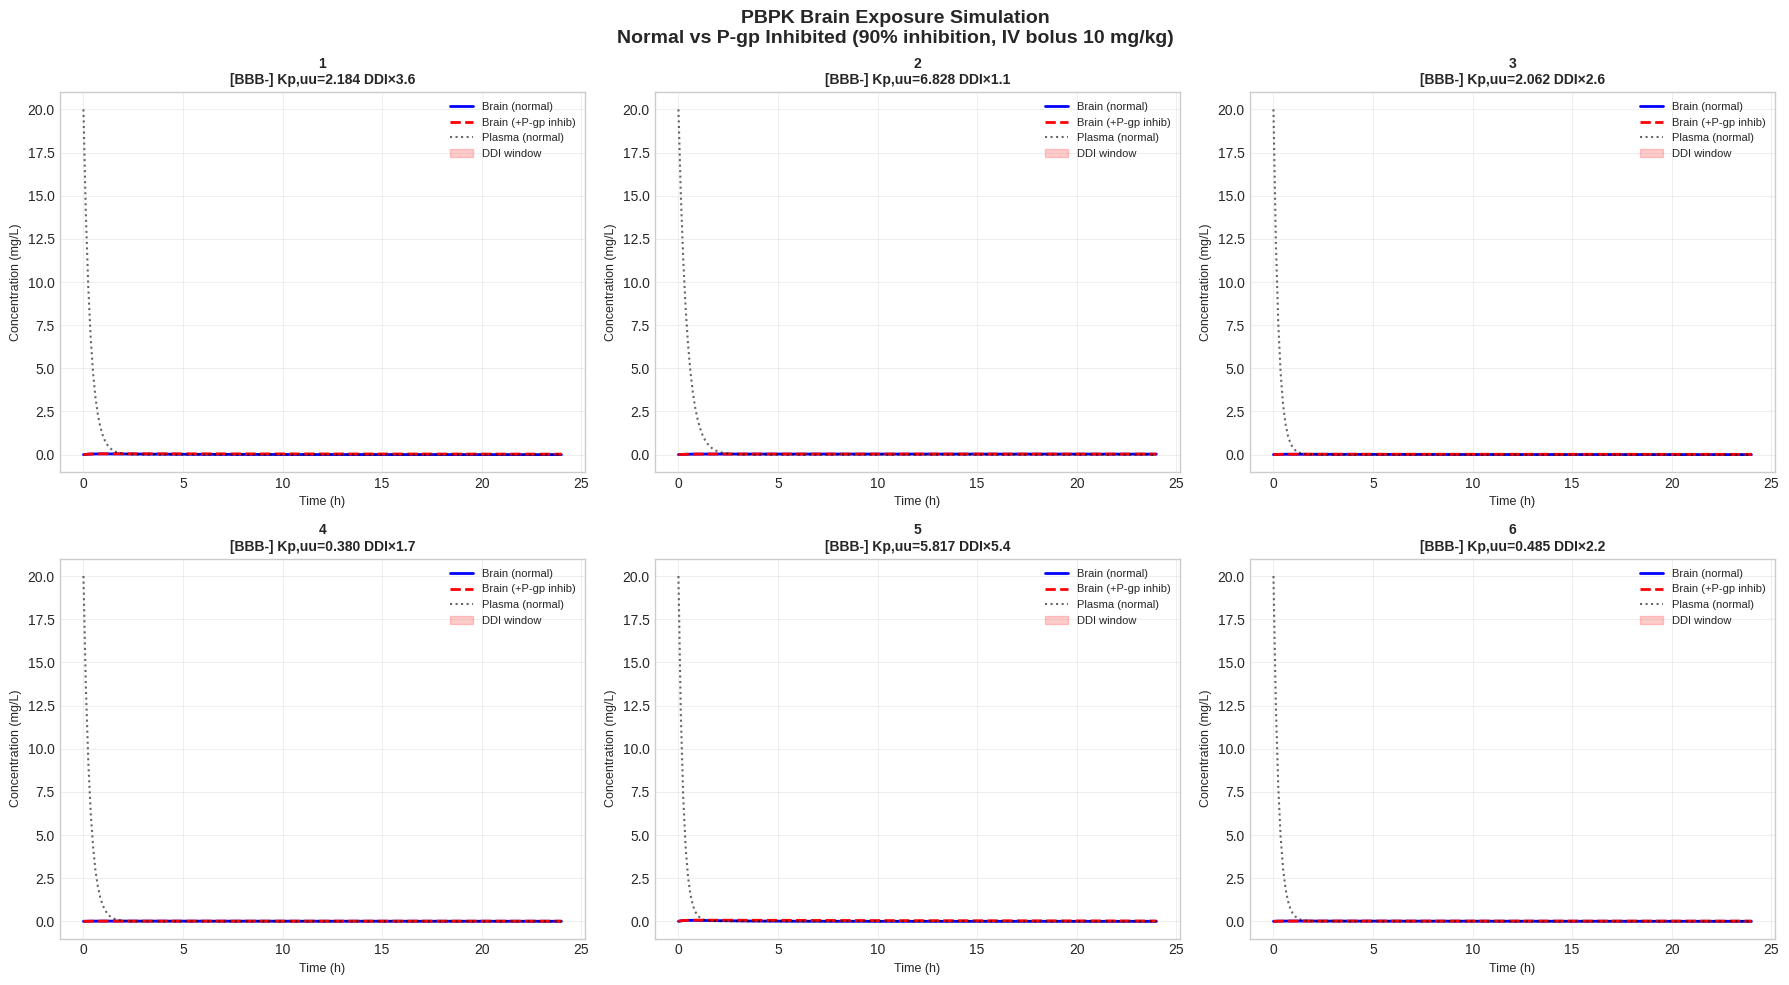


✅ PBPK simulation complete

📊 DDI Risk Distribution:
PBPK_DDI_Risk
🟡 Moderate DDI risk (2-5x)    32
🟢 Low DDI risk (<2x)          27
🔴 High DDI risk (>5x)          1


In [ ]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  CELL 13: LEVEL 3/4 – PBPK Simulation                       ║
# ║  Two-compartment (plasma + brain) ODE model                  ║
# ║  Simulates brain AUC under normal & P-gp inhibited conditions║
# ╚══════════════════════════════════════════════════════════════╝
print("="*60)
print(" LEVEL 3/4 → PBPK BRAIN EXPOSURE SIMULATION ")
print("="*60)
print("Two-compartment model: Plasma ↔ Brain")
print("Scenarios: Normal conditions vs P-gp inhibited (DDI)")
print()

# ── Two-compartment PBPK model ─────────────────────────────────
# dC_plasma/dt = -CL_total * C_plasma + Rate_in (dose)
# dC_brain/dt  = CL_diff * C_plasma - (CL_diff + CL_efflux) * C_brain
#
# Parameters derived from compound descriptors

def estimate_pbpk_params(row):
    """
    Estimate PBPK parameters from descriptors.
    All clearances in units of L/h/kg.
    """
    mw   = row.get('MW', 300)
    logp = row.get('LogP', 2)
    tpsa = row.get('TPSA', 60)
    fup  = max(0.005, row.get('fup', 0.1))
    ner  = row.get('P_gp_NER', 1.0)

    # Passive diffusion clearance (BBB permeability x surface area)
    # Higher logP & lower TPSA → faster passive diffusion
    cl_passive = 0.01 * np.exp(0.3 * logp - 0.015 * tpsa)
    cl_passive = np.clip(cl_passive, 0.0001, 0.5)

    # Efflux clearance (P-gp driven)
    cl_efflux  = cl_passive * (ner - 1)   # efflux = passive * (NER-1)
    cl_efflux  = max(0, cl_efflux)

    # Systemic clearance (hepatic + renal approximation)
    cl_systemic = np.clip(0.5 * mw / 300 * (1 - fup) * 2, 0.05, 5.0)

    return {
        'CL_passive':  cl_passive,
        'CL_efflux':   cl_efflux,
        'CL_systemic': cl_systemic,
        'Vd_plasma': 0.5,    # L/kg (typical CNS drug)
        'Vd_brain':  0.8,    # L/kg (typical brain Vd)
    }


def run_pbpk(params, dose_mg_kg=10, inhibit_pgp=False, inhibition_fraction=0.9, t_max=24):
    """
    Run 2-compartment PBPK ODE.
    Returns: t, C_plasma, C_brain, AUC_brain
    """
    CL_d = params['CL_passive']
    CL_e = params['CL_efflux'] * (1 - inhibition_fraction if inhibit_pgp else 1.0)
    CL_s = params['CL_systemic']
    Vp   = params['Vd_plasma']
    Vb   = params['Vd_brain']

    # Assume IV bolus equivalent (simplification)
    C0_plasma = dose_mg_kg / Vp

    def odes(t, y):
        Cp, Cb = y
        # Plasma: elimination + passive influx from brain
        dCp = -(CL_s/Vp + CL_d/Vp) * Cp + (CL_d + CL_e) / Vp * Cb
        # Brain: passive influx - passive outflux - efflux
        dCb = (CL_d / Vb) * Cp - (CL_d + CL_e) / Vb * Cb
        return [dCp, dCb]

    t_span = (0, t_max)
    t_eval = np.linspace(0, t_max, 200)
    sol = solve_ivp(odes, t_span, [C0_plasma, 0], t_eval=t_eval,
                    method='RK45', dense_output=True, rtol=1e-6)

    if sol.success:
        Cp = np.maximum(sol.y[0], 0)
        Cb = np.maximum(sol.y[1], 0)
        auc_brain  = np.trapz(Cb, sol.t)
        auc_plasma = np.trapz(Cp, sol.t)
        return sol.t, Cp, Cb, auc_brain, auc_plasma
    return t_eval, np.zeros_like(t_eval), np.zeros_like(t_eval), 0, 0


# ── Run PBPK for all predicted compounds ────────────────────────
pbpk_rows = []
for _, row in PRED_OUT.iterrows():
    params = estimate_pbpk_params(row)
    t, Cp, Cb, auc_b, auc_p   = run_pbpk(params, inhibit_pgp=False)
    _, _, Cb_inh, auc_b_inh, _ = run_pbpk(params, inhibit_pgp=True, inhibition_fraction=0.9)

    auc_b      = round(auc_b, 3)
    auc_b_inh  = round(auc_b_inh, 3)
    ddi_ratio  = round(auc_b_inh / (auc_b + 1e-9), 3)
    cmax_brain = round(float(np.max(Cb)), 4)

    pbpk_rows.append({
        'PBPK_AUC_Brain_Normal':   auc_b,
        'PBPK_AUC_Brain_Inhibited': auc_b_inh,
        'PBPK_DDI_Ratio':          ddi_ratio,
        'PBPK_Cmax_Brain':         cmax_brain,
        'PBPK_DDI_Risk': (
            '🔴 High DDI risk (>5x)' if ddi_ratio > 5 else
            ('🟡 Moderate DDI risk (2-5x)' if ddi_ratio > 2 else
             '🟢 Low DDI risk (<2x)')
        )
    })

pbpk_df = pd.DataFrame(pbpk_rows)
for col in pbpk_df.columns:
    PRED_OUT[col] = pbpk_df[col].values

# ── PBPK plots for top 6 compounds ──────────────────────────────
n_plot = min(6, len(PRED_OUT))
fig, axes = plt.subplots(2, 3, figsize=(18, 10)) if n_plot > 3 else plt.subplots(1, n_plot, figsize=(18, 5))
axes_flat = axes.flatten() if hasattr(axes, 'flatten') else [axes]

for i, (_, row) in enumerate(PRED_OUT.head(n_plot).iterrows()):
    params = estimate_pbpk_params(row)
    t_n, Cp_n, Cb_n, _, _     = run_pbpk(params, inhibit_pgp=False)
    t_i, Cp_i, Cb_i, _, _     = run_pbpk(params, inhibit_pgp=True, inhibition_fraction=0.9)

    ax = axes_flat[i]
    ax.plot(t_n, Cb_n, 'b-',  linewidth=2, label='Brain (normal)')
    ax.plot(t_i, Cb_i, 'r--', linewidth=2, label='Brain (+P-gp inhib)')
    ax.plot(t_n, Cp_n, 'k:',  linewidth=1.5, alpha=0.6, label='Plasma (normal)')
    ax.fill_between(t_i, Cb_n, Cb_i, alpha=0.2, color='red', label='DDI window')

    mol_name = row.get('Name', str(i+1))
    bbb_cls  = row.get('BEST_BBB_Class', '?')
    ddi_r    = row.get('PBPK_DDI_Ratio', 1)
    kp_uu    = row.get('Kp_uu_brain', 0)

    ax.set_title(f'{mol_name}\n[{bbb_cls}] Kp,uu={kp_uu:.3f} DDI×{ddi_r:.1f}',
                 fontsize=10, fontweight='bold')
    ax.set_xlabel('Time (h)', fontsize=9)
    ax.set_ylabel('Concentration (mg/L)', fontsize=9)
    ax.legend(fontsize=8); ax.grid(alpha=0.3)

plt.suptitle('PBPK Brain Exposure Simulation\nNormal vs P-gp Inhibited (90% inhibition, IV bolus 10 mg/kg)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plot_10_pbpk_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ PBPK simulation complete")
print("\n📊 DDI Risk Distribution:")
print(PRED_OUT['PBPK_DDI_Risk'].value_counts().to_string())

 LEVEL 5 → INTEGRATED DECISION DASHBOARD 


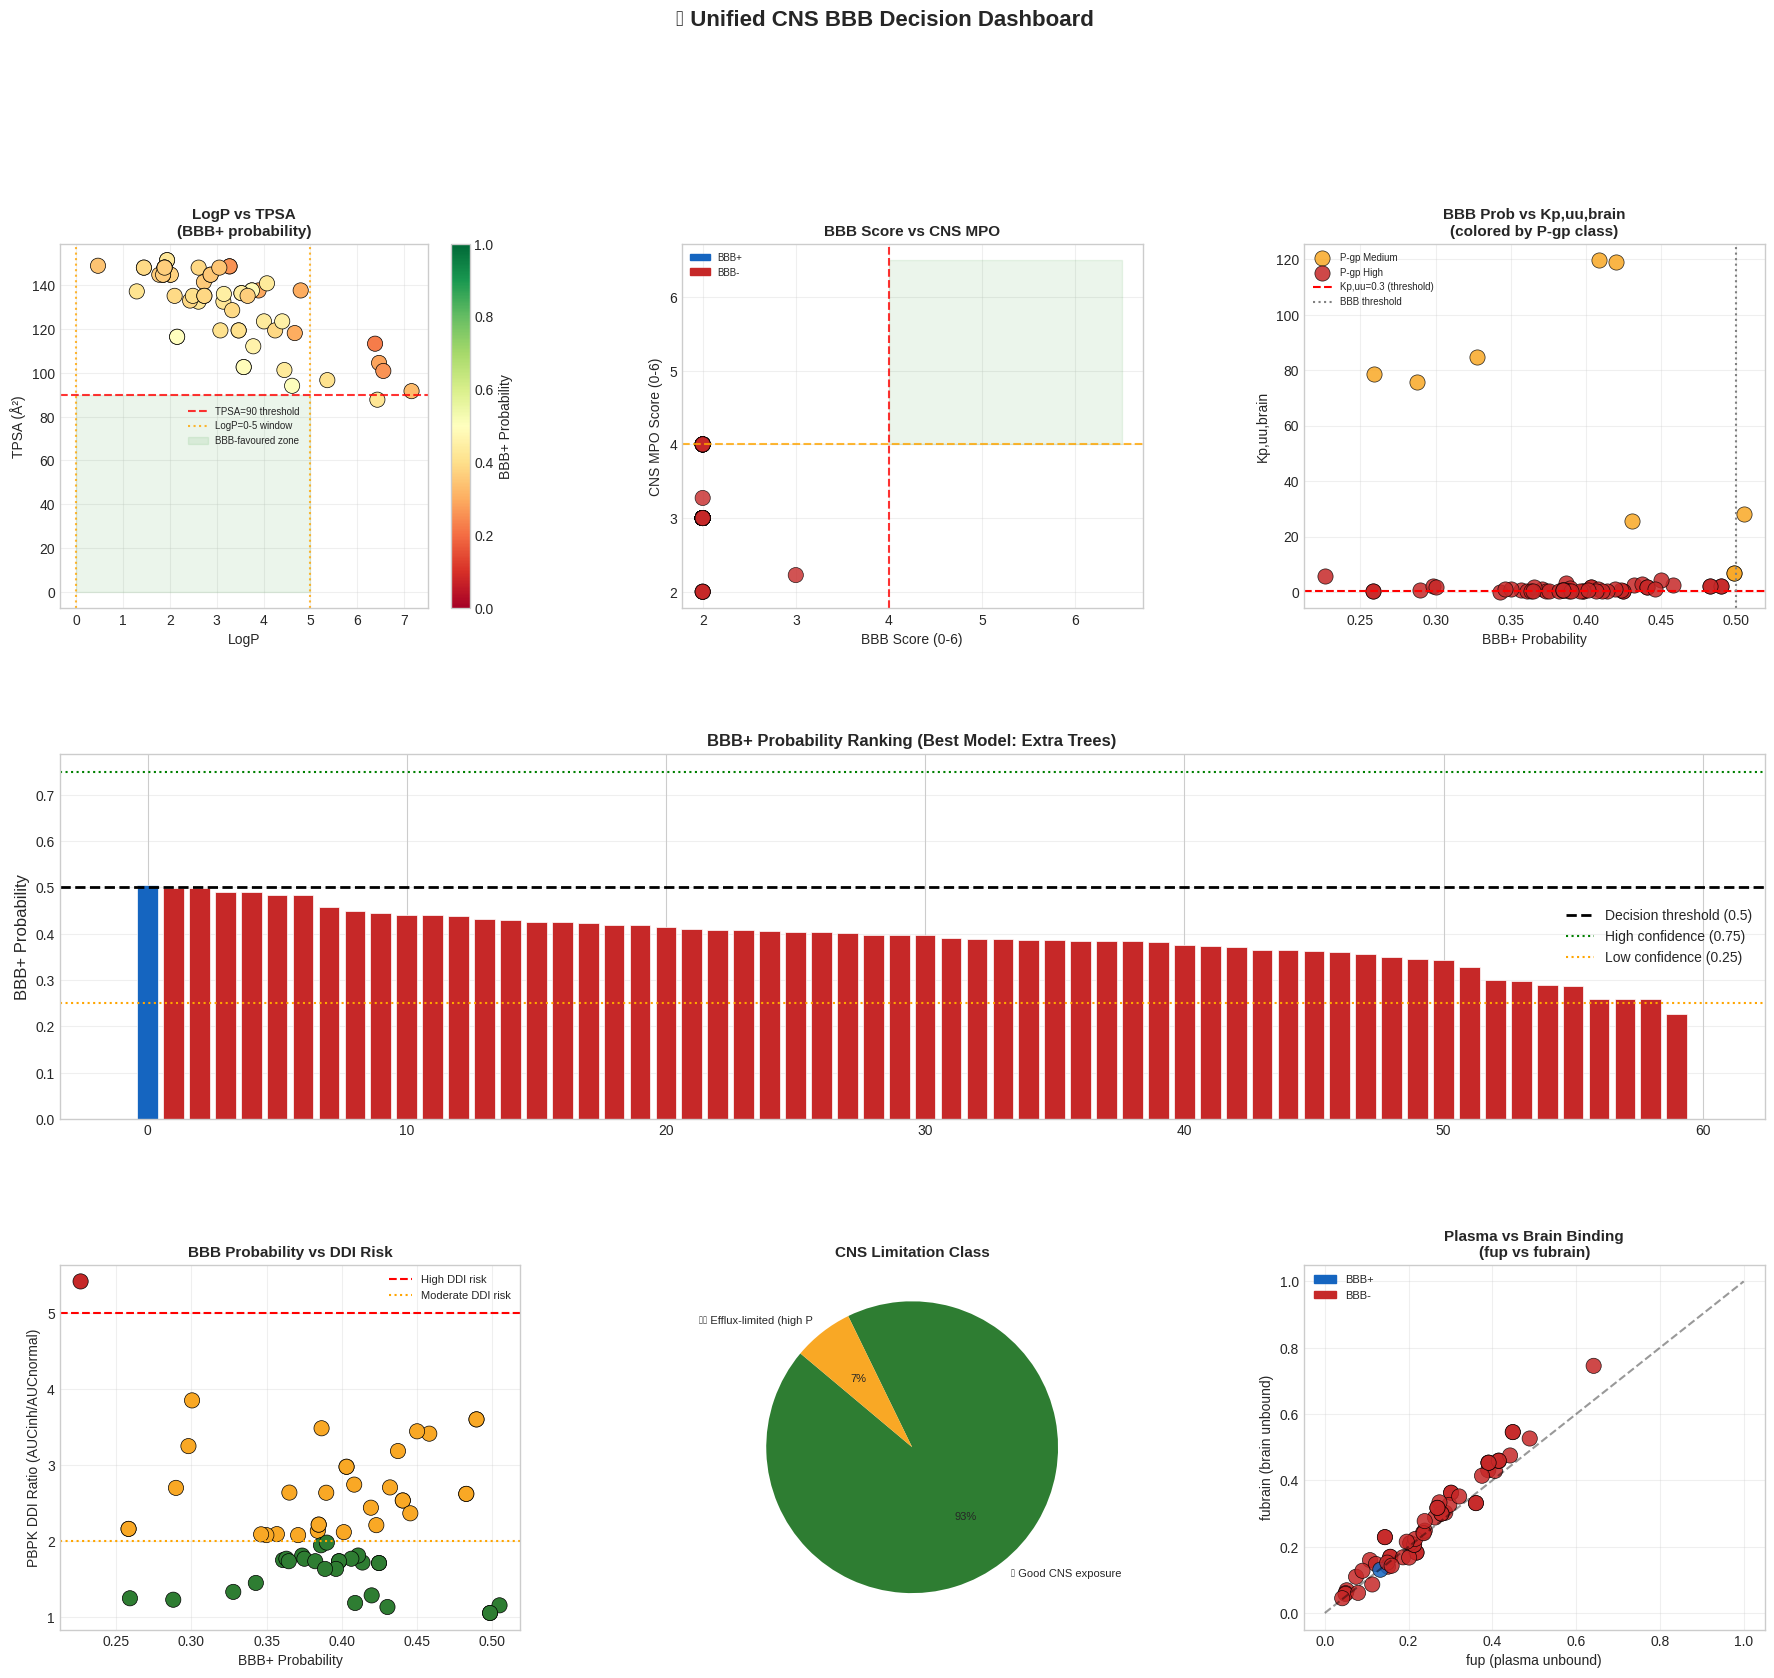

✅ Decision dashboard saved


In [ ]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  CELL 14: LEVEL 5 – Integrated Decision Dashboard           ║
# ╚══════════════════════════════════════════════════════════════╝
print("="*60)
print(" LEVEL 5 → INTEGRATED DECISION DASHBOARD ")
print("="*60)

# ── Plot: Chemical space + decision scatter ──────────────────────
fig = plt.figure(figsize=(22, 18))
gs  = GridSpec(3, 3, figure=fig, hspace=0.4, wspace=0.35)

# 1. LogP vs TPSA (BBB threshold zones)
ax1 = fig.add_subplot(gs[0, 0])
scatter1 = ax1.scatter(
    PRED_OUT['LogP'], PRED_OUT['TPSA'],
    c=PRED_OUT['BEST_BBB_Prob'], cmap='RdYlGn', s=120,
    edgecolors='black', linewidths=0.5, vmin=0, vmax=1
)
ax1.axhline(90, color='red', linestyle='--', linewidth=1.5, alpha=0.8, label='TPSA=90 threshold')
ax1.axvline(0, color='orange', linestyle=':', linewidth=1.5, alpha=0.8)
ax1.axvline(5, color='orange', linestyle=':', linewidth=1.5, alpha=0.8, label='LogP=0-5 window')
ax1.fill_between([0,5], [0,0], [90,90], alpha=0.08, color='green', label='BBB-favoured zone')
plt.colorbar(scatter1, ax=ax1, label='BBB+ Probability')
ax1.set_xlabel('LogP'); ax1.set_ylabel('TPSA (Å²)')
ax1.set_title('LogP vs TPSA\n(BBB+ probability)', fontsize=11, fontweight='bold')
ax1.legend(fontsize=7); ax1.grid(alpha=0.3)

# 2. BBB Score vs CNS MPO
ax2 = fig.add_subplot(gs[0, 1])
colors2 = ['#1565C0' if c=='BBB+' else '#C62828' for c in PRED_OUT['BEST_BBB_Class']]
ax2.scatter(PRED_OUT['BBB_Score'], PRED_OUT['CNS_MPO'],
             c=colors2, s=120, edgecolors='black', linewidths=0.5, alpha=0.8)
ax2.axvline(4, color='red', linestyle='--', linewidth=1.5, alpha=0.8, label='BBB Score = 4')
ax2.axhline(4, color='orange', linestyle='--', linewidth=1.5, alpha=0.8, label='CNS MPO = 4')
ax2.fill_between([4,6.5],[4,4],[6.5,6.5], alpha=0.08, color='green', label='Double pass zone')
bbb_pos = mpatches.Patch(color='#1565C0', label='BBB+'); bbb_neg = mpatches.Patch(color='#C62828', label='BBB-')
ax2.legend(handles=[bbb_pos, bbb_neg], fontsize=7, loc='upper left')
ax2.set_xlabel('BBB Score (0-6)'); ax2.set_ylabel('CNS MPO Score (0-6)')
ax2.set_title('BBB Score vs CNS MPO', fontsize=11, fontweight='bold'); ax2.grid(alpha=0.3)

# 3. Kp,uu,brain vs BBB Probability
ax3 = fig.add_subplot(gs[0, 2])
pgp_colors = {'Low':'#2E7D32','Medium':'#F9A825','High':'#C62828'}
for pgp_cls in ['Low','Medium','High']:
    mask = PRED_OUT['P_gp_Class'] == pgp_cls
    if mask.sum() > 0:
        ax3.scatter(PRED_OUT.loc[mask,'BEST_BBB_Prob'],
                     PRED_OUT.loc[mask,'Kp_uu_brain'],
                     c=pgp_colors[pgp_cls], s=120, edgecolors='black', linewidths=0.5,
                     label=f'P-gp {pgp_cls}', alpha=0.85)
ax3.axhline(0.3, color='red', linestyle='--', linewidth=1.5, label='Kp,uu=0.3 (threshold)')
ax3.axvline(0.5, color='gray', linestyle=':', linewidth=1.5, label='BBB threshold')
ax3.set_xlabel('BBB+ Probability'); ax3.set_ylabel('Kp,uu,brain')
ax3.set_title('BBB Prob vs Kp,uu,brain\n(colored by P-gp class)', fontsize=11, fontweight='bold')
ax3.legend(fontsize=7); ax3.grid(alpha=0.3)

# 4. Probability bar chart
ax4 = fig.add_subplot(gs[1, :])
sorted_df = PRED_OUT.sort_values('BEST_BBB_Prob', ascending=False)
bar_colors = ['#1565C0' if p >= 0.5 else '#C62828' for p in sorted_df['BEST_BBB_Prob']]
bars = ax4.bar(range(len(sorted_df)), sorted_df['BEST_BBB_Prob'], color=bar_colors,
                edgecolor='white', linewidth=0.5)
ax4.axhline(0.5,  color='black', linestyle='--', linewidth=2, label='Decision threshold (0.5)')
ax4.axhline(0.75, color='green', linestyle=':', linewidth=1.5, label='High confidence (0.75)')
ax4.axhline(0.25, color='orange', linestyle=':', linewidth=1.5, label='Low confidence (0.25)')

if 'Name' in sorted_df.columns:
    ax4.set_xticks(range(len(sorted_df)))
    ax4.set_xticklabels(sorted_df['Name'].tolist(), rotation=45, ha='right', fontsize=9)
ax4.set_ylabel('BBB+ Probability', fontsize=12)
ax4.set_title(f'BBB+ Probability Ranking (Best Model: {BEST_NAME})', fontsize=12, fontweight='bold')
ax4.legend(fontsize=10); ax4.grid(axis='y', alpha=0.3)

# 5. DDI risk scatter
ax5 = fig.add_subplot(gs[2, 0])
ddi_colors = ['#C62828' if r>5 else ('#F9A825' if r>2 else '#2E7D32') for r in PRED_OUT['PBPK_DDI_Ratio']]
ax5.scatter(PRED_OUT['BEST_BBB_Prob'], PRED_OUT['PBPK_DDI_Ratio'],
             c=ddi_colors, s=120, edgecolors='black', linewidths=0.5)
ax5.axhline(5, color='red', linestyle='--', linewidth=1.5, label='High DDI risk')
ax5.axhline(2, color='orange', linestyle=':', linewidth=1.5, label='Moderate DDI risk')
ax5.set_xlabel('BBB+ Probability'); ax5.set_ylabel('PBPK DDI Ratio (AUCinh/AUCnormal)')
ax5.set_title('BBB Probability vs DDI Risk', fontsize=11, fontweight='bold')
ax5.legend(fontsize=8); ax5.grid(alpha=0.3)

# 6. Limitation class pie chart
ax6 = fig.add_subplot(gs[2, 1])
lim_counts = PRED_OUT['Limitation_Class'].value_counts()
colors_pie = ['#2E7D32','#F9A825','#C62828','#1565C0','#6A1B9A','#E65100'][:len(lim_counts)]
ax6.pie(lim_counts.values, labels=[l[:25] for l in lim_counts.index],
         colors=colors_pie, autopct='%1.0f%%', startangle=140,
         textprops={'fontsize': 8})
ax6.set_title('CNS Limitation Class', fontsize=11, fontweight='bold')

# 7. fup vs fubrain
ax7 = fig.add_subplot(gs[2, 2])
ax7.scatter(PRED_OUT['fup'], PRED_OUT['fubrain'],
             c=['#1565C0' if c=='BBB+' else '#C62828' for c in PRED_OUT['BEST_BBB_Class']],
             s=120, edgecolors='black', linewidths=0.5, alpha=0.85)
ax7.plot([0,1],[0,1],'k--', alpha=0.4, label='fup = fubrain')
ax7.set_xlabel('fup (plasma unbound)'); ax7.set_ylabel('fubrain (brain unbound)')
ax7.set_title('Plasma vs Brain Binding\n(fup vs fubrain)', fontsize=11, fontweight='bold')
ax7.legend(handles=[bbb_pos,bbb_neg], fontsize=8); ax7.grid(alpha=0.3)

plt.suptitle('🧠 Unified CNS BBB Decision Dashboard', fontsize=16, fontweight='bold', y=1.01)
plt.savefig(f'{OUTPUT_DIR}/plot_11_decision_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Decision dashboard saved")

📊 Comparing descriptor profiles: Train Set vs Predicted Set...


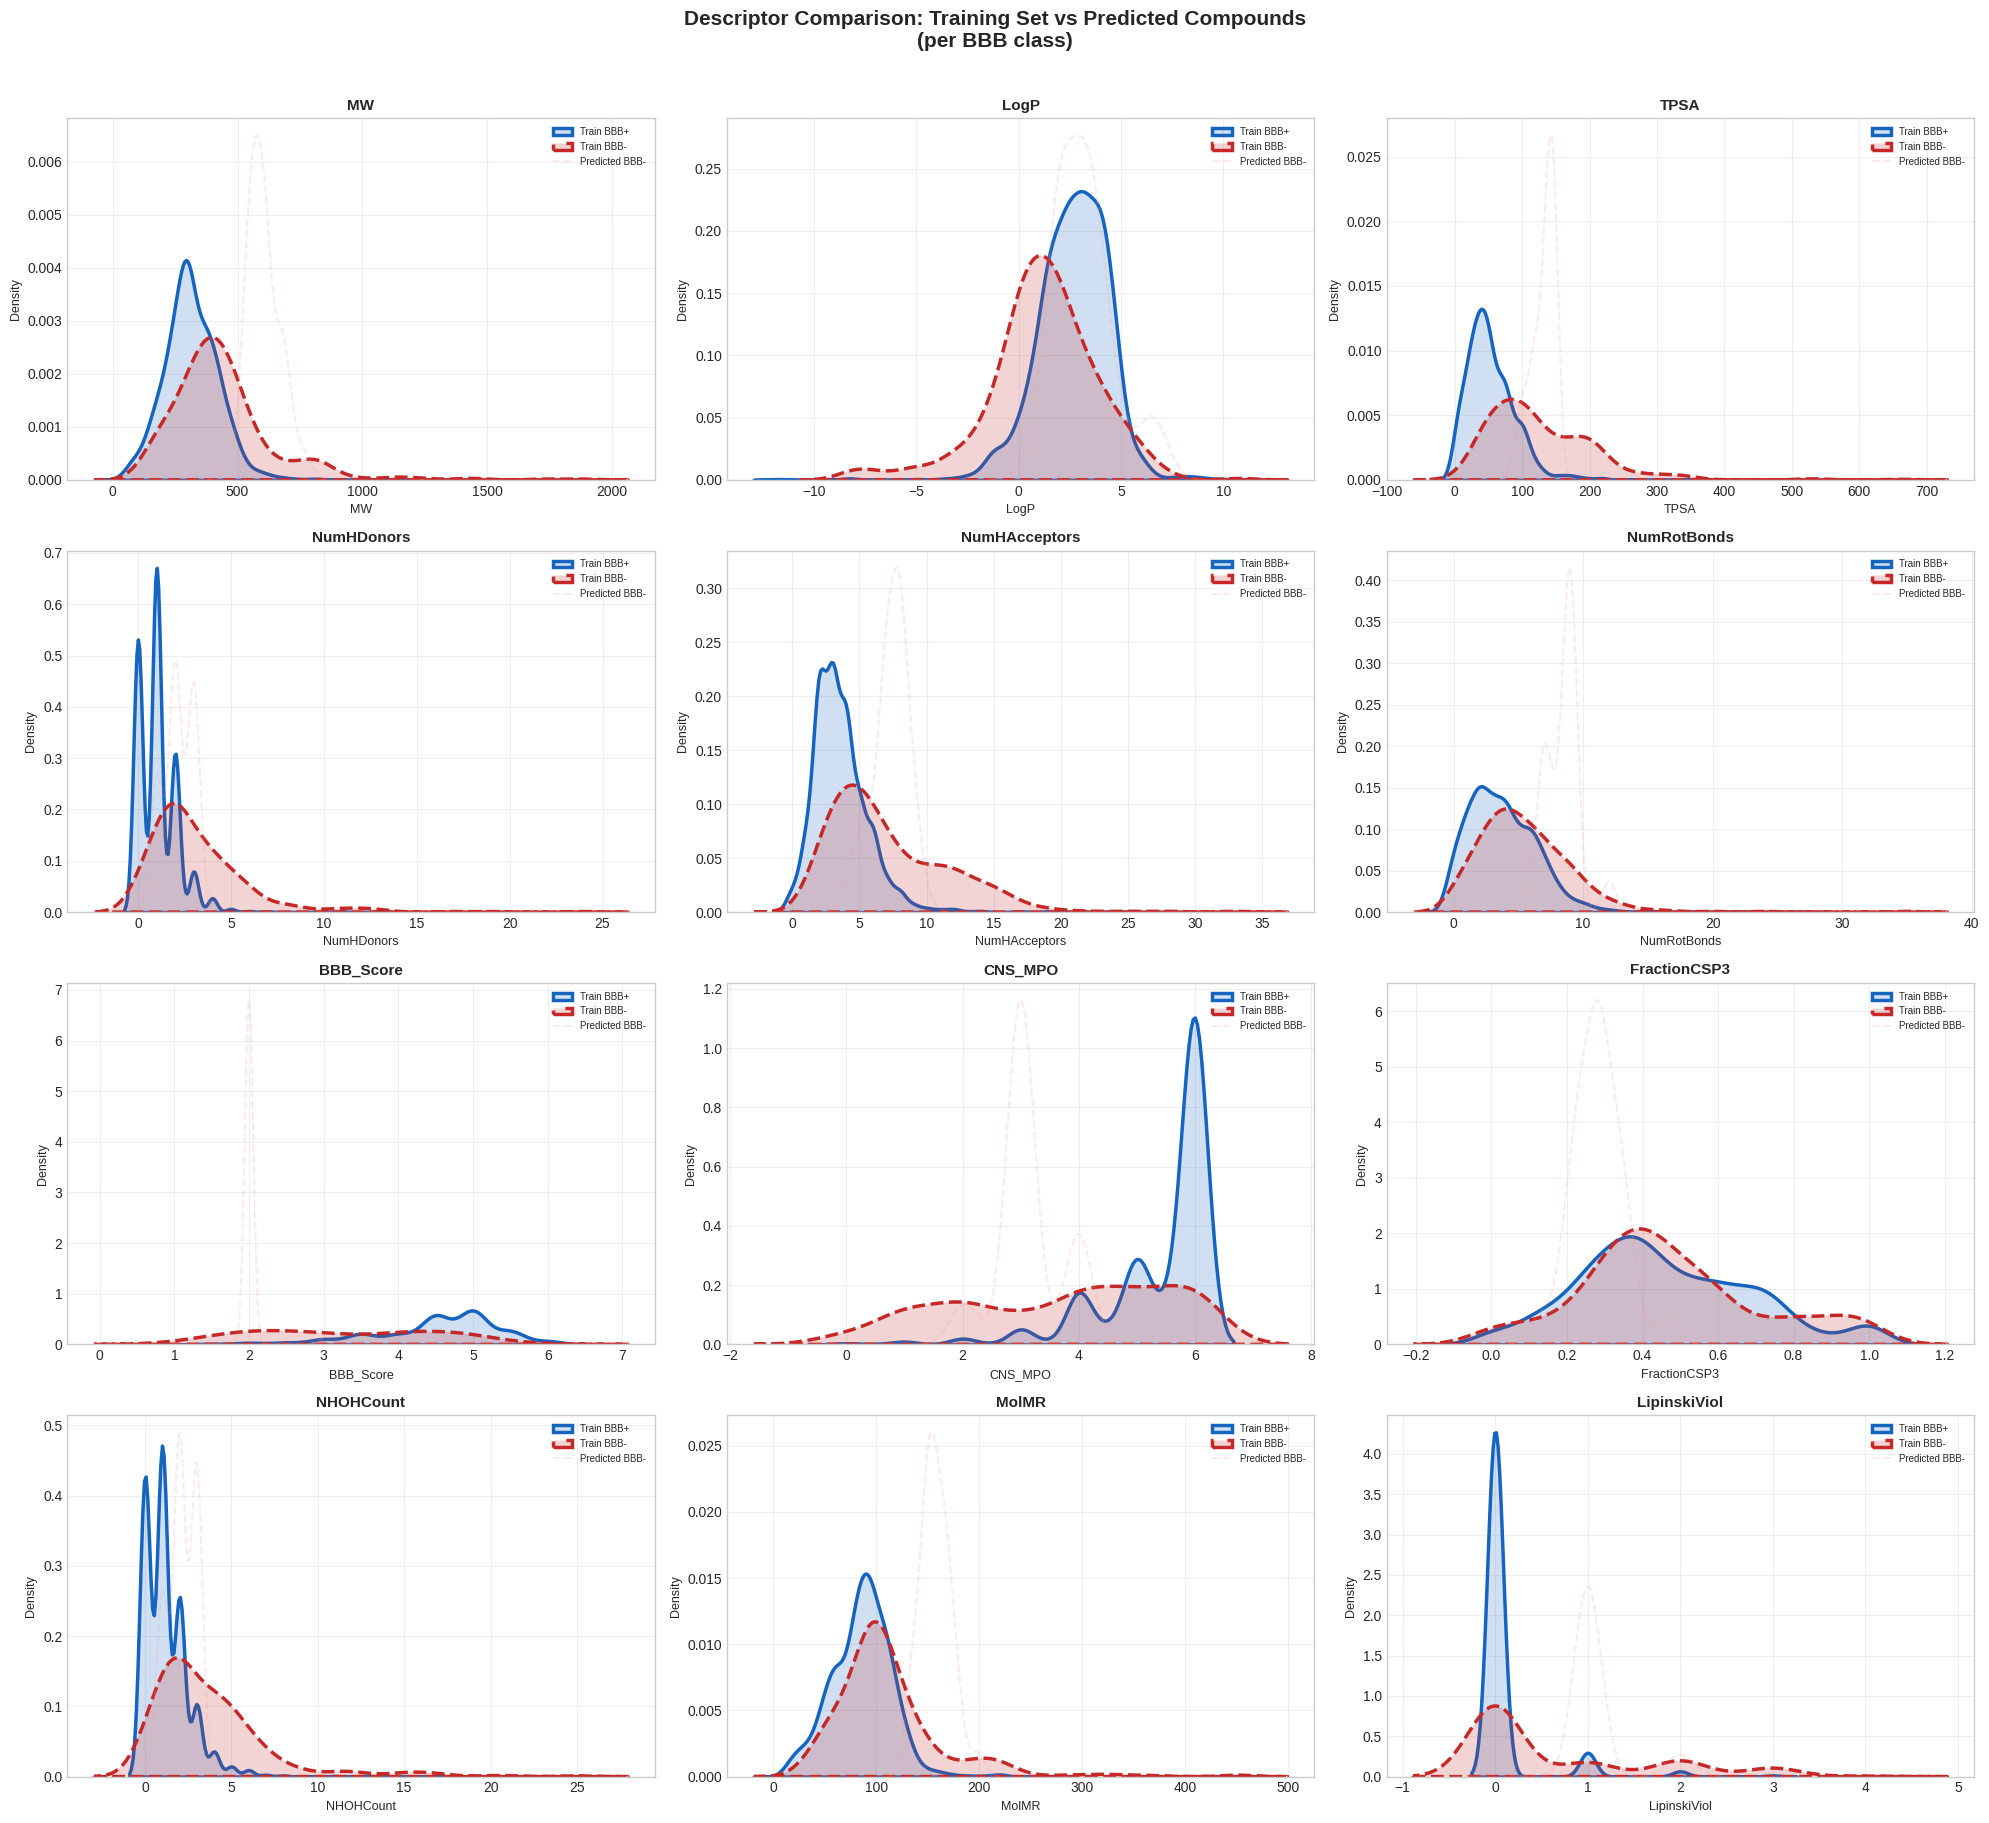

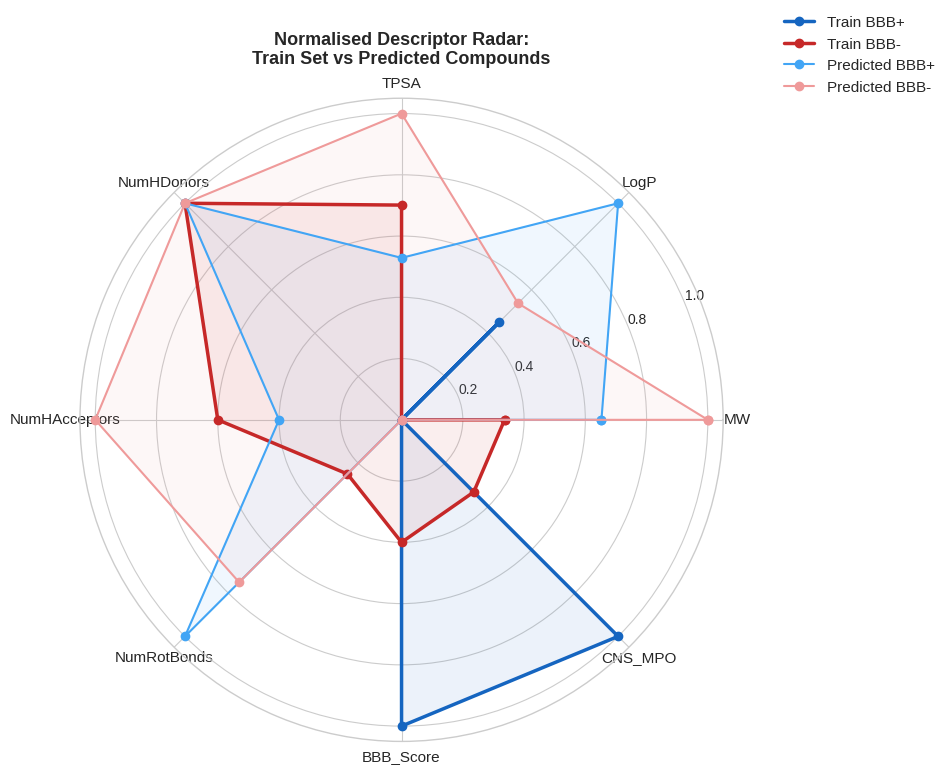

✅ Comparison plots saved


In [ ]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  CELL 15: Descriptor Comparison – Train vs Predicted        ║
# ║  BBB+ vs BBB- in both sets (radar + KDE)                    ║
# ╚══════════════════════════════════════════════════════════════╝
print("📊 Comparing descriptor profiles: Train Set vs Predicted Set...")

COMP_DESC = ['MW','LogP','TPSA','NumHDonors','NumHAcceptors',
              'NumRotBonds','BBB_Score','CNS_MPO','FractionCSP3',
              'NHOHCount','MolMR','LipinskiViol']

# ── Build comparison dataframe ────────────────────────────────
train_part = X_all[COMP_DESC].copy()
train_part['Group'] = np.where(y_all==1,'Train BBB+','Train BBB-')

user_part = PRED_OUT[[c for c in COMP_DESC if c in PRED_OUT.columns]].copy()
user_part['Group'] = np.where(PRED_OUT['BEST_BBB_Class'].values=='BBB+',
                               'Predicted BBB+','Predicted BBB-')
compare_df = pd.concat([train_part, user_part], ignore_index=True)

palette = {'Train BBB+':'#1565C0','Train BBB-':'#C62828',
            'Predicted BBB+':'#42A5F5','Predicted BBB-':'#EF9A9A'}

# KDE plots
fig, axes = plt.subplots(4, 3, figsize=(20, 18))
fig.suptitle('Descriptor Comparison: Training Set vs Predicted Compounds\n(per BBB class)',
             fontsize=15, fontweight='bold', y=1.01)

for i, col in enumerate(COMP_DESC):
    ax = axes.flatten()[i]
    for grp in ['Train BBB+','Train BBB-','Predicted BBB+','Predicted BBB-']:
        data = compare_df.loc[compare_df['Group']==grp, col].dropna()
        if len(data) > 2:
            lw = 2.5 if 'Train' in grp else 1.5
            ls = '-' if 'BBB+' in grp else '--'
            sns.kdeplot(data, ax=ax, label=grp, color=palette[grp],
                        fill=('Train' in grp), alpha=0.2, linewidth=lw, linestyle=ls)
    ax.set_title(col, fontsize=11, fontweight='bold')
    ax.set_xlabel(col, fontsize=9); ax.set_ylabel('Density', fontsize=9)
    ax.legend(fontsize=7); ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plot_12_train_vs_pred.png', dpi=150, bbox_inches='tight')
plt.show()

# Radar chart
radar_desc = ['MW','LogP','TPSA','NumHDonors','NumHAcceptors','NumRotBonds','BBB_Score','CNS_MPO']
medians = {}
for grp in ['Train BBB+','Train BBB-','Predicted BBB+','Predicted BBB-']:
    sub = compare_df[compare_df['Group']==grp]
    if len(sub) > 0:
        medians[grp] = sub[radar_desc].median()

if medians:
    med_df = pd.DataFrame(medians).T
    med_norm = (med_df - med_df.min()) / (med_df.max() - med_df.min() + 1e-9)

    N = len(radar_desc)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist(); angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(polar=True))
    for grp, color in palette.items():
        if grp in med_norm.index:
            vals = med_norm.loc[grp, radar_desc].tolist(); vals += vals[:1]
            lw = 2.5 if 'Train' in grp else 1.5
            ax.plot(angles, vals, 'o-', linewidth=lw, label=grp, color=color)
            ax.fill(angles, vals, alpha=0.08, color=color)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_desc, fontsize=11)
    ax.set_title('Normalised Descriptor Radar:\nTrain Set vs Predicted Compounds',
                 fontsize=13, fontweight='bold', pad=25)
    ax.legend(loc='upper right', bbox_to_anchor=(1.35,1.15), fontsize=11)
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/plot_13_radar.png', dpi=150, bbox_inches='tight')
    plt.show()

print("✅ Comparison plots saved")

In [ ]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  CELL 16: Export Complete Results to Multi-Sheet Excel       ║
# ╚══════════════════════════════════════════════════════════════╝
print("📊 Building comprehensive Excel report...")

EXCEL_PATH = f'{OUTPUT_DIR}/CNS_BBB_Complete_Results.xlsx'

# ── Styles ──────────────────────────────────────────────────────
def fill(h): return PatternFill('solid', start_color='FF'+h, end_color='FF'+h)
def fnt(h='000000', bold=False, sz=10):
    return Font(name='Arial', bold=bold, color='FF'+h, size=sz)
HDR_F=fill('1565C0'); HDR_T=fnt('FFFFFF',True,11)
SUB_F=fill('1976D2'); SUB_T=fnt('FFFFFF',True,10)
GLD_F=fill('FFD700'); GLD_T=fnt('000000',True,10)
POS_F=fill('E3F2FD'); NEG_F=fill('FFEBEE')
THIN=Border(left=Side(style='thin',color='FFCCCCCC'),right=Side(style='thin',color='FFCCCCCC'),
             top=Side(style='thin',color='FFCCCCCC'),bottom=Side(style='thin',color='FFCCCCCC'))
CTR=Alignment(horizontal='center',vertical='center',wrap_text=True)
LFT=Alignment(horizontal='left',vertical='center')

def style_hdr(ws, row, ncols, fl=HDR_F, fn=HDR_T):
    for c in range(1, ncols+1):
        cl=ws.cell(row,c); cl.fill=fl; cl.font=fn; cl.alignment=CTR; cl.border=THIN

def auto_w(ws):
    for col in ws.columns:
        w=max((len(str(c.value or '')) for c in col), default=8)
        ws.column_dimensions[get_column_letter(col[0].column)].width=min(w+3,40)

def write_df(ws, df, hr=2, dr=3):
    for j,c in enumerate(df.columns,1): ws.cell(hr,j,c)
    style_hdr(ws, hr, len(df.columns))
    ws.row_dimensions[hr].height=22
    for i,(_,row) in enumerate(df.iterrows(),dr):
        for j,v in enumerate(row,1):
            val=float(v) if isinstance(v,(np.floating,np.integer)) else v
            cl=ws.cell(i,j,val)
            cl.font=fnt(); cl.border=THIN; cl.alignment=LFT

def title(ws, text, span=14, row=1):
    ws.merge_cells(start_row=row,start_column=1,end_row=row,end_column=span)
    ws.cell(row,1,text).font=fnt('1565C0',True,14)
    ws.cell(row,1).alignment=CTR
    ws.row_dimensions[row].height=32

wb = Workbook()

# ── Sheet 1: PREDICTIONS (main output) ──────────────────────────
ws1 = wb.active; ws1.title = '1_Predictions'
ws1.sheet_view.showGridLines=False
title(ws1,'BBB PERMEABILITY PREDICTIONS — ALL UPLOADED COMPOUNDS')

pred_cols_xl = (
    [SMILES_COL] +
    [c for c in USER_DF.columns if c.lower()!='smiles'] +
    ['BEST_BBB_Prob','BEST_BBB_Class','Confidence_Tier','Ensemble_Class',
     'P_gp_Class','P_gp_NER','fup','fubrain','Kp_brain','Kp_uu_brain',
     'Limitation_Class','L1_Decision',
     'PBPK_AUC_Brain_Normal','PBPK_AUC_Brain_Inhibited','PBPK_DDI_Ratio','PBPK_DDI_Risk',
     'MW','LogP','TPSA','NumHDonors','NumHAcceptors','NumRotBonds',
     'BBB_Score','CNS_MPO','FractionCSP3','NHOHCount','LipinskiViol',
     'Ion_basic','Ion_acidic','Ion_neutral','QED']
)
pred_cols_xl = [c for c in pred_cols_xl if c in PRED_OUT.columns]
out_pred = PRED_OUT[pred_cols_xl].copy()
# Round numeric cols
for c in out_pred.select_dtypes(include=[float,np.floating]).columns:
    out_pred[c] = out_pred[c].round(4)
write_df(ws1, out_pred, hr=3, dr=4)

for i,(_,row) in enumerate(out_pred.iterrows(),4):
    lbl = row.get('BEST_BBB_Class','')
    fl  = POS_F if lbl=='BBB+' else NEG_F
    for c in range(1,len(out_pred.columns)+1): ws1.cell(i,c).fill=fl

# Color scale on probability
p_col = get_column_letter(out_pred.columns.get_loc('BEST_BBB_Prob')+1)
ws1.conditional_formatting.add(
    f'{p_col}4:{p_col}{4+len(out_pred)-1}',
    ColorScaleRule(start_type='num',start_value=0,start_color='FFFFCDD2',
                   end_type='num',end_value=1,end_color='FFC8E6C9'))
auto_w(ws1)

# ── Sheet 2: Model Statistics ────────────────────────────────────
ws2 = wb.create_sheet('2_Model_Statistics')
ws2.sheet_view.showGridLines=False
title(ws2,'MODEL PERFORMANCE STATISTICS — 10-Fold Stratified CV')
perf_xl = results_df[['Model','AUC_ROC','AUC_ROC_std','AUC_PR','AUC_PR_std',
                        'Accuracy','Accuracy_std','Balanced_Acc',
                        'F1','F1_std','Precision','Recall','MCC','OOF_AUC','Time_s']].copy()
write_df(ws2, perf_xl, hr=3, dr=4)
for c in range(1,len(perf_xl.columns)+1):
    ws2.cell(4,c).fill=GLD_F; ws2.cell(4,c).font=GLD_T  # gold = best model
ws2.conditional_formatting.add('B4:B9',
    ColorScaleRule(start_type='min',start_color='FFFFCDD2',end_type='max',end_color='FFC8E6C9'))

# Per-fold rows
fr = len(perf_xl)+6
ws2.cell(fr,1,'PER-FOLD AUC-ROC SCORES').font=fnt('1565C0',True,12)
fold_hdr=['Model']+[f'F{i}' for i in range(1,11)]+['Mean (=formula)','Std']
for j,h in enumerate(fold_hdr,1):
    cl=ws2.cell(fr+1,j,h); cl.fill=SUB_F; cl.font=SUB_T; cl.alignment=CTR; cl.border=THIN
for i,(mname,_) in enumerate(results_df.iterrows()):
    name=results_df.iloc[i]['Model']; r=fr+2+i
    ws2.cell(r,1,name).font=fnt(bold=True)
    folds=cv_store[name]['cv_res']['test_roc_auc']
    for f,v in enumerate(folds,2): ws2.cell(r,f,round(float(v),4)).font=fnt(); ws2.cell(r,f).border=THIN
    ws2.cell(r,12,f'=AVERAGE(B{r}:K{r})').font=fnt(bold=True); ws2.cell(r,12).fill=GLD_F
    ws2.cell(r,13,f'=STDEV(B{r}:K{r})').font=fnt()
ws2.conditional_formatting.add(f'B{fr+2}:K{fr+2+len(results_df)-1}',
    ColorScaleRule(start_type='min',start_color='FFFFCDD2',end_type='max',end_color='FFC8E6C9'))
auto_w(ws2)

# ── Sheet 3: Descriptor Stats ─────────────────────────────────
ws3 = wb.create_sheet('3_Descriptor_Stats')
ws3.sheet_view.showGridLines=False
title(ws3,'DESCRIPTOR STATISTICS — BBB+ vs BBB- (Mann-Whitney U)')
write_df(ws3, eda_df.round(4), hr=3, dr=4)
for i,(_,row) in enumerate(eda_df.iterrows(),4):
    fl=POS_F if row['Sig'] in ['*','**','***'] else NEG_F
    for c in range(1,len(eda_df.columns)+1): ws3.cell(i,c).fill=fl
ws3.conditional_formatting.add('G4:G'+str(4+len(eda_df)-1),
    ColorScaleRule(start_type='min',start_color='FFFFCDD2',mid_type='num',mid_value=0,mid_color='FFFFFFFF',end_type='max',end_color='FFC8E6C9'))
auto_w(ws3)

# ── Sheet 4: Feature Selection ─────────────────────────────────
ws4 = wb.create_sheet('4_Feature_Selection')
ws4.sheet_view.showGridLines=False
title(ws4,'FEATURE SELECTION — Variance → Correlation → Mutual Information')
mi_xl = mi_df[mi_df['feature'].isin(SELECTED_FEATURES)].round(4)
mi_xl.columns=['Feature','Mutual_Information_Score']
write_df(ws4, mi_xl, hr=3, dr=4)
ws4.conditional_formatting.add('B4:B'+str(4+len(mi_xl)-1),
    ColorScaleRule(start_type='min',start_color='FFFFF9C4',end_type='max',end_color='FFF57F17'))
vif_start=len(mi_xl)+6
ws4.cell(vif_start,1,'VIF Analysis').font=fnt('1565C0',True,12)
write_df(ws4, vif_df.round(2), hr=vif_start+1, dr=vif_start+2)
for i,(_,row) in enumerate(vif_df.iterrows(),vif_start+2):
    fl=fill('FFCDD2') if row['VIF']>10 else (fill('FFF9C4') if row['VIF']>5 else fill('C8E6C9'))
    ws4.cell(i,2).fill=fl
auto_w(ws4)

# ── Sheet 5: SHAP Summary ──────────────────────────────────────
if not shap_df.empty:
    ws5 = wb.create_sheet('5_SHAP_Summary')
    ws5.sheet_view.showGridLines=False
    title(ws5,'SHAP FEATURE IMPORTANCE — All Models')
    write_df(ws5, shap_df.round(5), hr=3, dr=4)
    for i,(_,row) in enumerate(shap_df.iterrows(),4):
        fl=POS_F if '↑' in str(row.get('Direction','')) else NEG_F
        for c in [4]: ws5.cell(i,c).fill=fl
    auto_w(ws5)

# ── Sheet 6: Mechanistic PK ────────────────────────────────────
ws6 = wb.create_sheet('6_Mechanistic_PK')
ws6.sheet_view.showGridLines=False
title(ws6,'MECHANISTIC PK DECOMPOSITION — Kp,brain & Kp,uu,brain (J.Med.Chem. 2021 framework)')
mech_xl_cols=['BEST_BBB_Class','P_gp_Class','P_gp_NER','fup','fubrain',
               'Kp_brain','Kp_uu_brain','Limitation_Class','L1_Decision']
base_cols = [SMILES_COL] + [c for c in USER_DF.columns if c.lower()!='smiles']
mech_xl_show = PRED_OUT[[c for c in base_cols+mech_xl_cols if c in PRED_OUT.columns]].copy()
for c in mech_xl_show.select_dtypes(include=[float]).columns:
    mech_xl_show[c]=mech_xl_show[c].round(5)
write_df(ws6, mech_xl_show, hr=3, dr=4)
for i,(_,row) in enumerate(mech_xl_show.iterrows(),4):
    lc=row.get('Limitation_Class','')
    fl=(fill('C8E6C9') if '✅' in str(lc) else (fill('FFF9C4') if '⚠' in str(lc) else fill('FFCDD2')))
    for c in range(1,len(mech_xl_show.columns)+1): ws6.cell(i,c).fill=fl
auto_w(ws6)

# ── Sheet 7: PBPK Results ──────────────────────────────────────
ws7 = wb.create_sheet('7_PBPK_Results')
ws7.sheet_view.showGridLines=False
title(ws7,'PBPK SIMULATION RESULTS — Brain AUC Normal vs P-gp Inhibited (DDI)')
pbpk_cols=['BEST_BBB_Class','P_gp_Class','Kp_uu_brain',
           'PBPK_AUC_Brain_Normal','PBPK_AUC_Brain_Inhibited',
           'PBPK_DDI_Ratio','PBPK_Cmax_Brain','PBPK_DDI_Risk']
pbpk_show = PRED_OUT[[c for c in base_cols+pbpk_cols if c in PRED_OUT.columns]].copy()
for c in pbpk_show.select_dtypes(include=[float]).columns:
    pbpk_show[c]=pbpk_show[c].round(4)
write_df(ws7, pbpk_show, hr=3, dr=4)
for i,(_,row) in enumerate(pbpk_show.iterrows(),4):
    ddi=row.get('PBPK_DDI_Risk','')
    fl=(fill('FFCDD2') if '🔴' in str(ddi) else (fill('FFF9C4') if '🟡' in str(ddi) else fill('C8E6C9')))
    for c in range(1,len(pbpk_show.columns)+1): ws7.cell(i,c).fill=fl
ws7.conditional_formatting.add('G4:G'+str(4+len(pbpk_show)-1) if len(pbpk_show)>0 else 'G4:G4',
    ColorScaleRule(start_type='min',start_color='FFC8E6C9',end_type='max',end_color='FFFFCDD2'))
auto_w(ws7)

# ── Sheet 8: Training Data ─────────────────────────────────────
ws8 = wb.create_sheet('8_Training_Data')
ws8.sheet_view.showGridLines=False
title(ws8,'TRAINING DATA — BBBP Benchmark + All Descriptors')
key_desc=['MW','LogP','TPSA','NumHDonors','NumHAcceptors','NumRotBonds',
           'BBB_Score','CNS_MPO','FractionCSP3','NHOHCount','LipinskiViol','QED']
train_xl=pd.DataFrame({'SMILES':smiles_train,'BBB_Label':['BBB+' if y==1 else 'BBB-' for y in y_all]})
kd=X_all[[c for c in key_desc if c in X_all.columns]].reset_index(drop=True)
train_xl=pd.concat([train_xl,kd],axis=1)
write_df(ws8, train_xl.round(4), hr=3, dr=4)
for i,(_,row) in enumerate(train_xl.iterrows(),4):
    fl=POS_F if row['BBB_Label']=='BBB+' else NEG_F
    ws8.cell(i,2).fill=fl
auto_w(ws8)

# ── Sheet 9: Thresholds Reference ─────────────────────────────
ws9 = wb.create_sheet('9_Thresholds_Reference')
ws9.sheet_view.showGridLines=False
title(ws9,'BBB DECISION RULES & THRESHOLDS — Complete Reference',span=8)
thr_hdr=['Descriptor','BBB+ Threshold','BBB- Flag','Source','Direction','Class','Notes']
thr_rows=[
    ('TPSA','< 90 Å²','> 120 Å²','Spielvogel 2024','Lower=better','A-Physicochemical','#1 SHAP predictor; Spielvogel used 3D PSA + Boltzmann conformers'),
    ('3D PSA (Spielvogel)','< 90 Å²','> 120 Å²','Spielvogel 2024 (novel)','Lower=better','A-Physicochemical','Novel 3D descriptor; more accurate for flexible molecules'),
    ('LogP','1.0-5.0','<0 or >5','Lipinski/CNS MPO','Moderate optimal','A-Physicochemical','Optimal CNS logP = 1-3; passive diffusion driven'),
    ('MolWt','< 450 Da','> 500 Da','Lipinski/BBB Score','Lower=better','A-Physicochemical','CNS optimal < 360 Da'),
    ('NumHDonors','≤ 3','> 5','Lipinski/CNS MPO','Lower=better','A-Physicochemical','Strongest CNS predictor; each HBD reduces logBB by ~0.3'),
    ('NumHAcceptors','≤ 8','> 10','CNS MPO','Lower=better','A-Physicochemical','HBA count affects desolvation energy'),
    ('NumRotBonds','≤ 8','> 10','CNS MPO','Lower=better','B-Topological','Flexibility cost at BBB lipid membrane'),
    ('BBB Score (Gupta)','≥ 4','< 3','Gupta et al. 2019','Higher=more BBB+','A-Physicochemical','Score 0-6; MW, HBD/HBA, TPSA, aromatic rings'),
    ('CNS MPO','≥ 4','< 3','Wager et al. 2010','Higher=better','A-Physicochemical','Pfizer CNS design score; 6 params, max=6'),
    ('FractionCSP3','> 0.25','< 0.10','Literature','Higher=better','B-Topological','sp3 fraction promotes 3D shape & solubility'),
    ('NHOHCount','≤ 3','> 5','Literature','Lower=better','A-Physicochemical','Combined OH+NH count; H-bond donor atoms'),
    ('LogBB (exp)','>-1','< -1','Literature','Higher=better','A-Physicochemical','log(Cbrain/Cblood); > 0.3 = good, -1 to 0.3 = moderate'),
    ('Kp,uu,brain','> 0.3','< 0.1','JMedChem 2021','Higher=better','PK','Unbound brain/plasma; integrates permeability + binding + efflux'),
    ('fup','compound-dependent','< 0.01','JMedChem 2021','Higher = more free drug','PK','Plasma unbound fraction; <1% = high binding'),
    ('fubrain','compound-dependent','< 0.005','JMedChem 2021','Higher = more free drug','PK','Brain unbound fraction; key for Kp,uu calc'),
    ('P-gp NER (Low)','NER ~1.0','—','JMedChem 2021','Low efflux','D-Binary','Negligible P-gp efflux; minimal DDI risk'),
    ('P-gp NER (Medium)','NER ~2.2','—','JMedChem 2021','Moderate efflux','D-Binary','Moderate efflux; 2x DDI under inhibition'),
    ('P-gp NER (High)','NER ~26.3','—','JMedChem 2021','Strong efflux','D-Binary','Dominates BBB; redesign or efflux inhibition needed'),
]
for j,h in enumerate(thr_hdr,1):
    ws9.cell(3,j,h); ws9.cell(3,j).fill=HDR_F; ws9.cell(3,j).font=HDR_T
    ws9.cell(3,j).alignment=CTR; ws9.cell(3,j).border=THIN
for i,row in enumerate(thr_rows,4):
    alt=fill('F5F5F5') if i%2==0 else fill('FFFFFF')
    if 'Spielvogel' in str(row[3]): alt=fill('FFF9C4')
    for c,v in enumerate(row,1):
        cl=ws9.cell(i,c,v); cl.fill=alt; cl.font=fnt(sz=9); cl.border=THIN; cl.alignment=LFT
    ws9.row_dimensions[i].height=20
for cl,w in zip('ABCDEFG',[22,16,14,22,16,18,52]): ws9.column_dimensions[cl].width=w

wb.save(EXCEL_PATH)
print(f"\n✅ Excel saved: {EXCEL_PATH}")
print(f"   Sheets: {[ws.title for ws in wb.worksheets]}")

📊 Building comprehensive Excel report...

✅ Excel saved: /content/BBB_Results/CNS_BBB_Complete_Results.xlsx
   Sheets: ['1_Predictions', '2_Model_Statistics', '3_Descriptor_Stats', '4_Feature_Selection', '5_SHAP_Summary', '6_Mechanistic_PK', '7_PBPK_Results', '8_Training_Data', '9_Thresholds_Reference']


In [ ]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  CELL 17: Package and Download All Results                  ║
# ╚══════════════════════════════════════════════════════════════╝
print("📦 Packaging all results...")

ZIP_PATH = f'{OUTPUT_DIR}/CNS_BBB_Pipeline_Results.zip'
plots    = sorted(glob.glob(f'{OUTPUT_DIR}/plot_*.png'))

with zipfile.ZipFile(ZIP_PATH, 'w', zipfile.ZIP_DEFLATED) as zf:
    zf.write(EXCEL_PATH, 'CNS_BBB_Complete_Results.xlsx')
    for p in plots:
        zf.write(p, 'plots/' + os.path.basename(p))

print(f"\n📦 ZIP: {ZIP_PATH}")
print("\nContents:")
print("  📊 CNS_BBB_Complete_Results.xlsx")
print("     ├── 1_Predictions         — All compounds with BBB class + mechanistic PK + PBPK + decisions")
print("     ├── 2_Model_Statistics     — 10-fold CV stats + per-fold AUC table")
print("     ├── 3_Descriptor_Stats     — Mann-Whitney + point-biserial per descriptor")
print("     ├── 4_Feature_Selection    — MI scores + VIF table")
print("     ├── 5_SHAP_Summary         — SHAP mean |values| per model")
print("     ├── 6_Mechanistic_PK       — P-gp class, fup, fubrain, Kp,brain, Kp,uu,brain")
print("     ├── 7_PBPK_Results         — Brain AUC normal vs inhibited + DDI ratio")
print("     ├── 8_Training_Data        — Full BBBP benchmark with descriptors")
print("     └── 9_Thresholds_Reference — Complete decision rules reference")
for p in plots:
    print(f"  🖼️  {os.path.basename(p)}")

if IN_COLAB:
    print("\n⬇️  Downloading ZIP and Excel...")
    files.download(ZIP_PATH)
    files.download(EXCEL_PATH)
    print("✅ Downloads initiated!")

# ── Final summary ────────────────────────────────────────────────
print("\n" + "="*65)
print(" 🏁  PIPELINE COMPLETE ")
print("="*65)
print(f" Training compounds : {len(X_all)}")
print(f" Descriptors used   : {len(SELECTED_FEATURES)} selected from {X_all.shape[1]}")
print(f" Best ML model      : {BEST_NAME}")
print(f" AUC-ROC            : {results_df.iloc[0]['AUC_ROC']:.4f} ± {results_df.iloc[0]['AUC_ROC_std']:.4f}")
print(f" F1 Score           : {results_df.iloc[0]['F1']:.4f} ± {results_df.iloc[0]['F1_std']:.4f}")
print(f" MCC                : {results_df.iloc[0]['MCC']:.4f}")
print(f" Predicted BBB+     : {int((PRED_OUT['BEST_BBB_Class']=='BBB+').sum())} / {len(PRED_OUT)}")
print(f" High DDI risk      : {(PRED_OUT['PBPK_DDI_Risk'].str.contains('High')).sum()} compounds")
print("="*65)
print()
print(" TIERED DECISIONS:")
for dec, cnt in PRED_OUT['L1_Decision'].value_counts().items():
    print(f"   {dec}: {cnt} compounds")
print("="*65)

📦 Packaging all results...

📦 ZIP: /content/BBB_Results/CNS_BBB_Pipeline_Results.zip

Contents:
  📊 CNS_BBB_Complete_Results.xlsx
     ├── 1_Predictions         — All compounds with BBB class + mechanistic PK + PBPK + decisions
     ├── 2_Model_Statistics     — 10-fold CV stats + per-fold AUC table
     ├── 3_Descriptor_Stats     — Mann-Whitney + point-biserial per descriptor
     ├── 4_Feature_Selection    — MI scores + VIF table
     ├── 5_SHAP_Summary         — SHAP mean |values| per model
     ├── 6_Mechanistic_PK       — P-gp class, fup, fubrain, Kp,brain, Kp,uu,brain
     ├── 7_PBPK_Results         — Brain AUC normal vs inhibited + DDI ratio
     ├── 8_Training_Data        — Full BBBP benchmark with descriptors
     └── 9_Thresholds_Reference — Complete decision rules reference
  🖼️  plot_01_distributions.png
  🖼️  plot_02_correlations.png
  🖼️  plot_03_corr_heatmap.png
  🖼️  plot_04_roc_pr.png
  🖼️  plot_05_model_comparison.png
  🖼️  plot_06_confusion.png
  🖼️  plot_07_cv_boxplo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloads initiated!

 🏁  PIPELINE COMPLETE 
 Training compounds : 2039
 Descriptors used   : 36 selected from 66
 Best ML model      : Extra Trees
 AUC-ROC            : 0.9268 ± 0.0260
 F1 Score           : 0.9287 ± 0.0113
 MCC                : 0.6894
 Predicted BBB+     : 1 / 60
 High DDI risk      : 1 compounds

 TIERED DECISIONS:
   ❌ Kill or redesign (strong P-gp efflux): 50 compounds
   ⚠️ Flag for further investigation: 8 compounds
   ✅ Advance (moderate P-gp, good BBB): 1 compounds
   ❌ Deprioritize CNS (high TPSA + low logP): 1 compounds
